In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

In [6]:
# helper function to print messages
def cprint(title, *args):
    print(
        "="*len(title), title, "="*len(title),
        *args,
        sep="\n",
    )

In [7]:
train = pd.read_csv('./train.csv', parse_dates=["date"])
test = pd.read_csv('./test.csv', parse_dates=["date"])

oil = pd.read_csv('./oil.csv', parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv('./stores.csv')
transaction = pd.read_csv('./transactions.csv', parse_dates=['date'])
holiday = pd.read_csv('./holidays_events.csv', parse_dates=['date'])

In [8]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [9]:
cprint(
    "Basic information of data",
    f"Number of family types      : {num_family}",
    f"Number of stores            : {num_store}",
    f"Number of store-family pairs: {num_family * num_store}",
    f"Number of target series     : {num_ts}",
    "",
    f"Number of unique train dates: {num_train_date}",
    f"Train date range            : {train_len} days from {train_start} to {train_end}",
    f"Number of unique test dates : {num_test_date}",
    f"Test date range             : {test_len} days from {test_start} to {test_end}",
)

Basic information of data
Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782
Number of target series     : 1782

Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Number of unique test dates : 16
Test date range             : 16 days from 2017-08-16 to 2017-08-31


In [10]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [11]:
cprint(
    "Missing gaps in time series",
    f"List incl. unique counts of data points: {unique_dp_count}",
    f"Missing dates                          : {missing_dates}",
)

Missing gaps in time series
List incl. unique counts of data points: [1684]
Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [12]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

In [13]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [14]:
cprint(
    "Missing oil dates",
    f"Number of missing oil dates: {num_missing_oil_dates}",
    f"Number of weekends missing : {num_wknd_missing}",
    f"Total number of weekends   : {total_num_wknd}",
)

Missing oil dates
Number of missing oil dates: 486
Number of weekends missing : 486
Total number of weekends   : 486


In [15]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [16]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transaction.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [17]:
cprint(
    "Missing transaction records",
    f"Correct number of records: {total_rec}",
    "",
    "Breakdown...",
    f"Current number of records: {curr_rec}",
    f"Number of zero sales     : {num_zero_sales}",
    f"Number of missing records: {missing_rec}",
)

Missing transaction records
Correct number of records: 91152

Breakdown...
Current number of records: 83488
Number of zero sales     : 7546
Number of missing records: 118


In [18]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

Что касается наших данных о праздниках, мы отмечаем, что существуют праздники разного масштаба (национальные, региональные и местные). При этом региональные праздники соответствуют государственному уровню, а местные – городскому. Это можно проверить, проверив столбец locale_name, а также столбцы города и штата в данных магазина.


In [19]:
national_locale_name = sorted(holiday[holiday.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(holiday[holiday.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(holiday[holiday.locale.eq("Local")].locale_name.unique().tolist())

In [20]:
cprint(
    "List of locale names for each holiday",
    "Locale names for national holidays:",
    national_locale_name,
    "",
    "Locale names for regional holidays:",
    regional_locale_name,
    "",
    "Locale names for local holidays:",
    local_locale_name,
)

List of locale names for each holiday
Locale names for national holidays:
['Ecuador']

Locale names for regional holidays:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

Locale names for local holidays:
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


Проверить: Есть много праздников схожего характера, которые можно сгруппировать для упрощения моделирования.
В данных о праздничных днях некоторые дни, окружающие фактические праздничные дни, также помечены как праздничные. Ниже показан пример для Рождества (Навидад) 2012 г., где такие термины, как «-4» и «+1», указывают количество дней до и после Рождества. Мы можем проверить, что в целом эти ближайшие дни помечены как «Дополнительные» в столбце типа. Кроме того, поскольку Рождество 2012 года выпадает на вторник, 24 декабря 2012 года объявлен выходным днем, чтобы сделать выходные длинными. Мы можем сгруппировать такие праздники вместе для стандартизации.

In [21]:
holiday[(holiday.description.str.contains("Navidad"))&(holiday.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


Оказывается, есть и другие примеры, например День Независимости для разных городов. Для простоты предположим, что такие праздники должны иметь одинаковое влияние на продажи в магазине. Мы присваиваем такие же ярлыки таким праздникам, удаляя лишние слова, такие как мост (puente) и названия городов/штатов, из столбца описания. Функция для обработки столбца приведена ниже.


In [22]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [23]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


Далее мы обрабатываем данные о праздниках, удаляя перенесенные праздники. Это можно проверить с помощью переданной колонки. Поскольку праздники не отмечаются в официальную дату и больше похожи на обычные дни, мы их исключаем.

Затем мы разделяем их на национальные/региональные/местные праздники и субботы, которые считаются рабочими днями. Префиксы nat_ / loc_ устанавливаются для национальных/местных праздников, чтобы лучше различать их при последующей визуализации. По региональным праздникам получается, что у нас только провинциализация, вот она и маркируется. Ниже показан пример, где национальные праздники кодируются как фиктивные переменные. То же самое относится и к другим праздникам.

In [24]:
# remove transferred holidays
holiday = holiday[holiday.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Исследование данных:

После предварительной обработки данных мы теперь можем анализировать наши данные и обнаруживать закономерности с помощью визуализаций. Прежде чем мы это сделаем, мы преобразуем наши данные из длинной формы в широкую форму, где каждый столбец соответствует одному временному ряду. С любой формой может быть легче работать в различных ситуациях. Ниже показан пример для нашего целевого ряда, где индекс — это измерение времени, представленное датой, а столбцы — это продажи для каждой пары магазин-семейство.

In [25]:
sales_ts = pd.pivot_table(train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transaction, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

В целях визуализации необходимо масштабировать наши данные, если мы хотим посмотреть среднее значение столбца продаж. Это помогает сбалансировать влияние всех пар «магазин-семейство» на среднее значение. То же самое относится к транзакциям и значениям onpromotion, но мы будем масштабировать их только при необходимости позже.

Мы также преобразуем масштабированные данные о продажах в полную форму и добавляем столбцы праздников, чтобы позже проанализировать влияние праздников. Дополнительный столбец no_holiday вычисляется для указания дней без праздников. Это важно, когда мы сравниваем продажи в магазине в праздничные и непраздничные периоды.

In [26]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,
).reset_index().merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Вывод: в целом количество нулевых продаж со временем уменьшается. Помимо Рождества, в Новый год также наблюдается большое количество нулевых продаж.
Начнем с подсчета количества целевых серий с нулевыми продажами за каждый день. Количество нулевых продаж имеет общую тенденцию к снижению, что свидетельствует о том, что периоды без продаж становятся менее частыми и что магазины постоянно генерируют положительные продажи. Это может быть связано с изменениями в некоторых ковариатах, имеющих временную связь с цифрами продаж, которые мы исследуем позже.

Помимо Рождества, у нас также есть большое количество нулевых продаж в Новый год на протяжении многих лет. Точно так же многие магазины могут быть закрыты по этому поводу, что мы должны принять во внимание в наших моделях позже. Интересно, что в период с 2014 по 2015 год количество нулевых продаж сильно колеблется.

Dates with zero sales
Dates (excl. Christmas) with zero sales: ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
Corresponding counts of zero sales     : [1765, 1732, 1759, 1753, 1754]
Total number of target series          : 1782


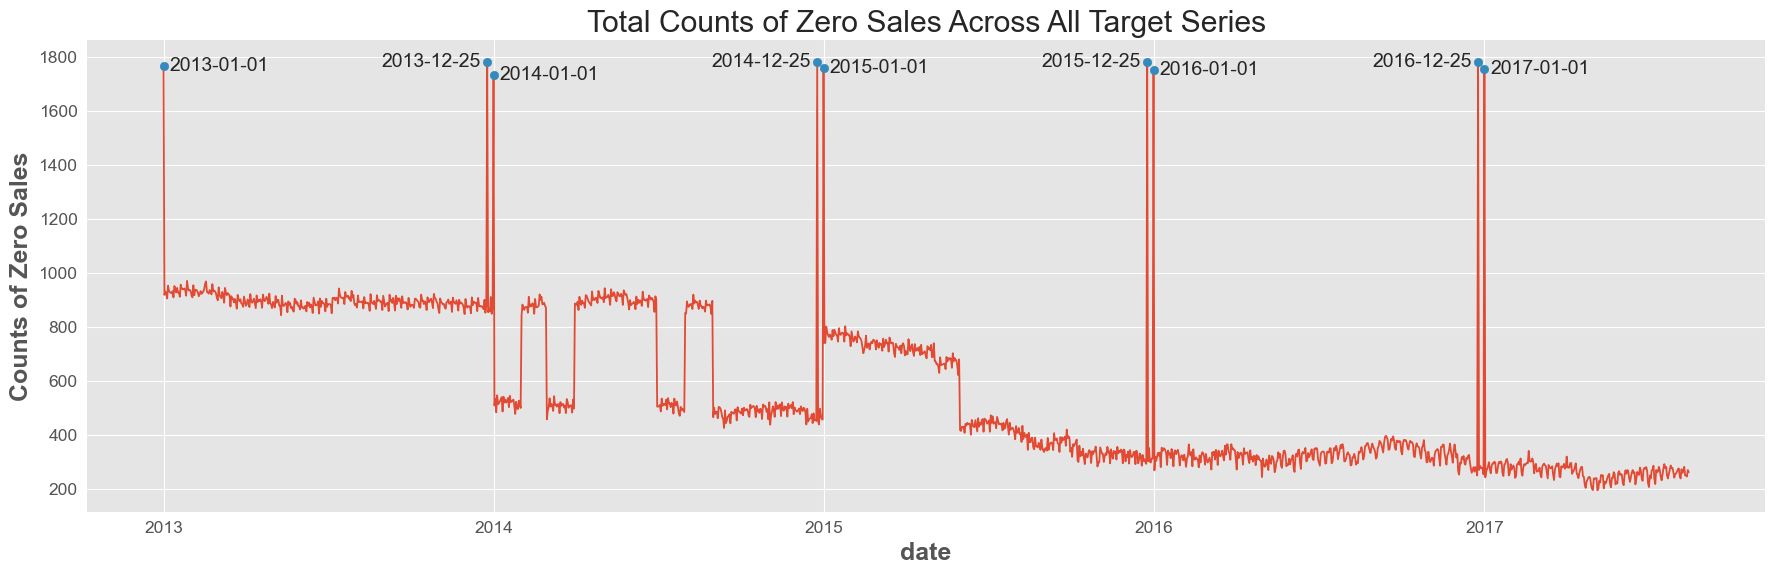

In [27]:
def plot_zero_count_ts():
    zero_count_ts = (sales_ts.eq(0)).sum(axis=1).to_frame("zero_sales_ct").reset_index()
    zero_count_filtered = zero_count_ts[zero_count_ts.zero_sales_ct.gt(1500)].reset_index(drop=True)
    high_zero_dates = zero_count_filtered.date.dt.strftime("%Y-%m-%d")
    high_zero_dates = [d for d in high_zero_dates if not d.endswith("12-25")]
    high_zero_counts = zero_count_filtered[zero_count_filtered.date.isin(high_zero_dates)].zero_sales_ct.tolist()

    cprint(
        "Dates with zero sales",
        f"Dates (excl. Christmas) with zero sales: {high_zero_dates}",
        f"Corresponding counts of zero sales     : {high_zero_counts}",
        f"Total number of target series          : {num_ts}",
    )

    plt.figure(figsize=(18, 6))

    sns.lineplot(data=zero_count_ts, x="date", y="zero_sales_ct")
    sns.scatterplot(
        data=zero_count_filtered, x="date", y="zero_sales_ct",
        color=COLORS[1],
        edgecolor=COLORS[1],
        zorder=2,
    )
    for j in range(len(zero_count_filtered.index)):
        ha = "left" if j%2==0 else "right"
        offset = pd.Timedelta(7, "d") if ha=="left" else pd.Timedelta(-7, "d")
        plt.text(
            x=zero_count_filtered.date[j]+offset, y=zero_count_filtered.zero_sales_ct[j],
            s=zero_count_filtered.date[j].strftime("%Y-%m-%d"),
            ha=ha,
            va="center",
            size=14,
        )
    plt.ylabel("Counts of Zero Sales")
    plt.title("Total Counts of Zero Sales Across All Target Series")
    plt.tight_layout()
    plt.show()

plot_zero_count_ts()


Вывод: существуют целевые ряды, все значения которых равны нулю.
Наши обучающие данные содержат 53 целевых ряда, все значения которых равны нулю. Это может быть связано с плохими продажами или отсутствием продукта. Что здесь интересно, так это то, что все магазины имеют от 0 до 3 нулевых постоянных целевых серий. Если мы рассмотрим это по семейству продуктов, книги имеют наибольшее количество нулевых постоянных целевых серий. Похоже, что проблема нулевых продаж может быть связана с типом продаваемого продукта.

In [59]:
sales_ts

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                        ...        54             \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES      MEATS   
date                                             ...                        
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771000   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257000   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223000   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431000   
...                ...      ...    ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       0.0  50.756000   
2017-08-12         3.0    351.0  526.0   99.488  ...       1.0  53.079002   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  67.435000   
2017-08-14         4.0    571.0  699.0  154.578  ...       1.0  64.224000   
2017-08-15        21.0    703.0  602.0  116.402  ...       2.0  57.842000   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2013-01-01           0.0          0.0                     0.0   0.000000   
2013-01-02         228.0          0.0                     0.0  15.514000   
2013-01-03         156.0          0.0                     0.0   4.313000   
2013-01-04         146.0          0.0                     0.0  26.743000   
2013-01-05         205.0          0.0                     0.0  31.118000   
...                  ...          ...                     ...        ...   
2017-08-11         155.0          0.0                     0.0  80.759000   
2017-08-12         169.0          0.0                     4.0  91.671000   
2017-08-13         244.0          0.0                     2.0  79.062996   
2017-08-14         200.0          0.0                     1.0  56.155000   
2017-08-15         169.0          0.0                     2.0  59.619000   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2013-01-01            0.0    0.000                        0.0     0.0  
2013-01-02           61.0    0.000                        0.0     3.0  
2013-01-03            1.0    0.000                        0.0     2.0  
2013-01-04           38.0    0.000                        0.0     2.0  
2013-01-05           32.0    0.000                        0.0     1.0  
...                   ...      ...                        ...     ...  
2017-08-11           54.0  546.250                        0.0     0.0  
2017-08-12           81.0  696.920                        0.0     1.0  
2017-08-13           91.0  877.304                        0.0     2.0

In [60]:
sales_ts.std()

store_nbr  family                    
1          AUTOMOTIVE                      2.760863
           BABY CARE                       0.000000
           BEAUTY                          1.900311
           BEVERAGES                     730.103095
           BOOKS                           0.535976
                                            ...    
54         POULTRY                        26.619475
           PREPARED FOODS                 28.630210
           PRODUCE                       318.124744
           SCHOOL AND OFFICE SUPPLIES      2.963222
           SEAFOOD                         2.259190
Length: 1782, dtype: float64

Constant target series
Number of constant target series: 53
List of unique constant values  : [0.0]


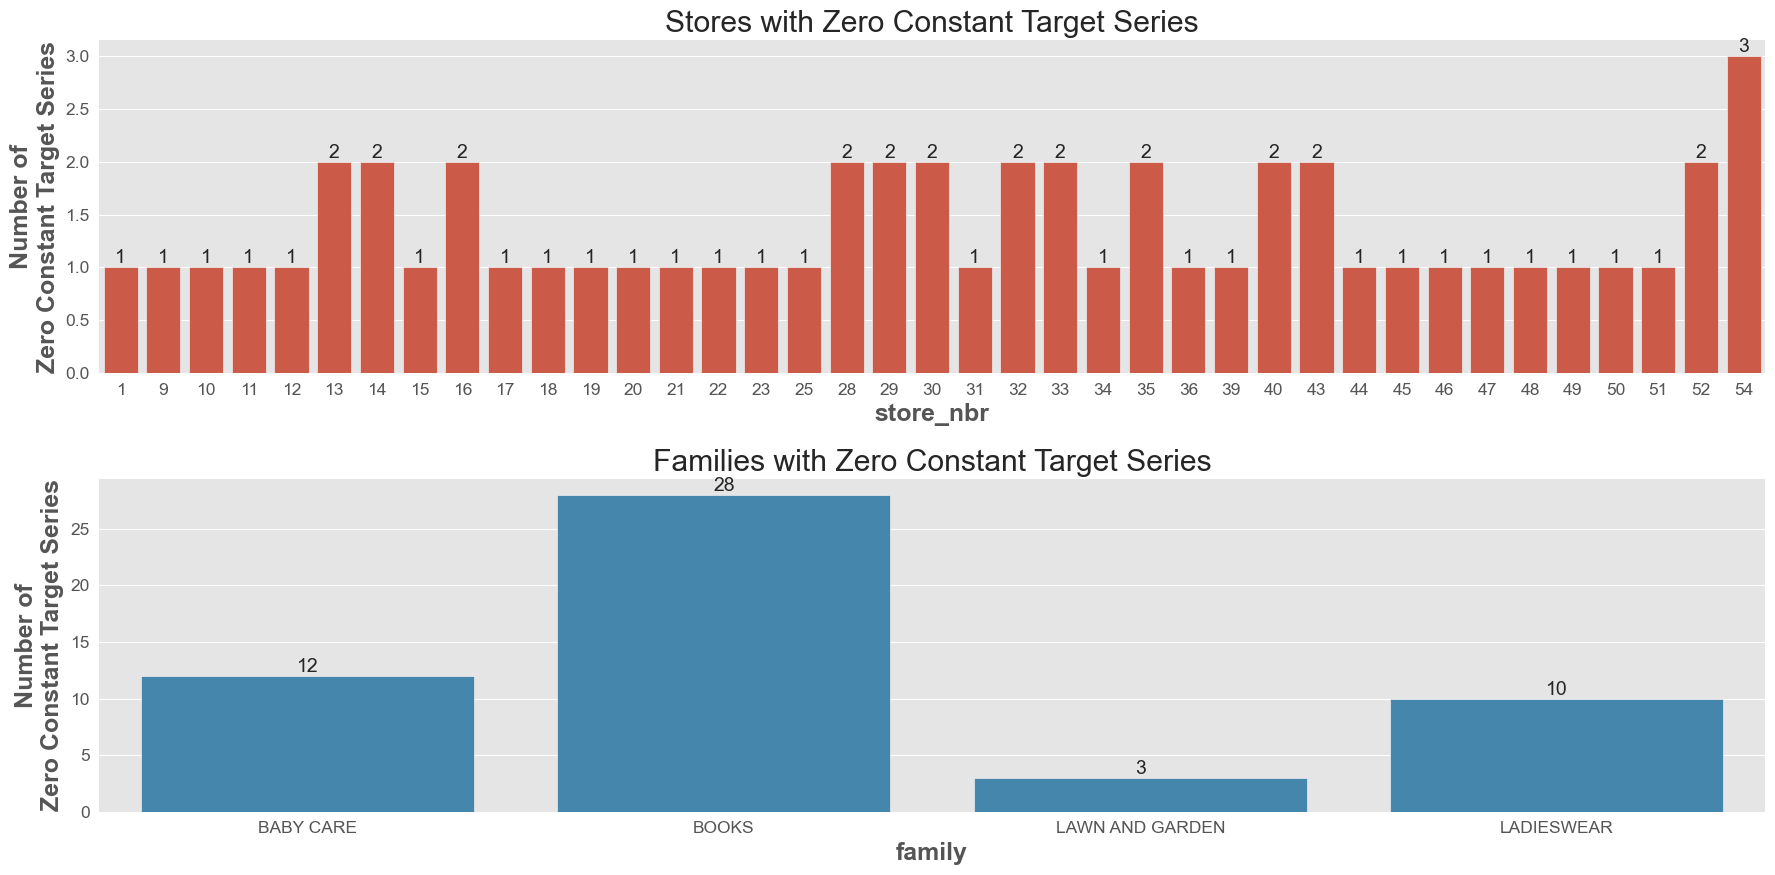

In [28]:
def plot_constant_ts_distribution():
    const_ts = sales_ts.iloc[:, (sales_ts.std()==0).tolist()]
    const_ts_labels = const_ts.columns.to_frame().reset_index(drop=True)

    cprint(
        "Constant target series",
        f"Number of constant target series: {len(const_ts.columns)}",
        f"List of unique constant values  : {const_ts.iloc[0].unique().tolist()}",
    )

    fig = plt.figure(figsize=(18, 9))

    ax0 = sns.countplot(
        data=const_ts_labels, x="store_nbr",
        color=COLORS[0],
        ax=fig.add_subplot(211),
    )
    ax0.bar_label(ax0.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Stores with Zero Constant Target Series")

    ax1 = sns.countplot(
        data=const_ts_labels, x="family",
        color=COLORS[1],
        ax=fig.add_subplot(212),
    )
    ax1.bar_label(ax1.containers[0], size=14)
    plt.ylabel("Number of\nZero Constant Target Series")
    plt.title("Families with Zero Constant Target Series")

    plt.tight_layout()
    plt.show()

plot_constant_ts_distribution()


Вывод: существует много целевых рядов с ведущими нулями.
Мы рассмотрим некоторые возможные модели нулевых продаж в магазине. Целевой ряд с нулевой константой удаляется, чтобы получить лучшее представление об оставшихся целевых рядах. Получается, что у нас есть много целевых рядов с ведущими нулями, причем некоторые ряды состоят из тысяч ведущих нулей. Это говорит о возможной недоступности продукта или просто низкой эффективности продаж на начальном этапе.

Мы отмечаем, что распределение начальных нулей довольно стабильно по магазинам, и только в нескольких магазинах ящики расположены выше остальных. Примерами являются магазины с номерами 52, 53. Это может означать, что некоторые магазины открылись совсем недавно, поэтому в начале целевой серии продаж нет.

С другой стороны, распределение начальных нулей варьируется в зависимости от семейства продуктов. Это говорит о том, что проблема начальных нулей может быть связана с типом продуктов, например, целевая серия для книг, каждая из которых имеет тысячи начальных нулей. Это подтверждает предыдущий вывод выше.

Time series with leading zeros (excluding zero constant target series)
Total number of time series                : 1729
Number of time series with >1 leading zeros: 865


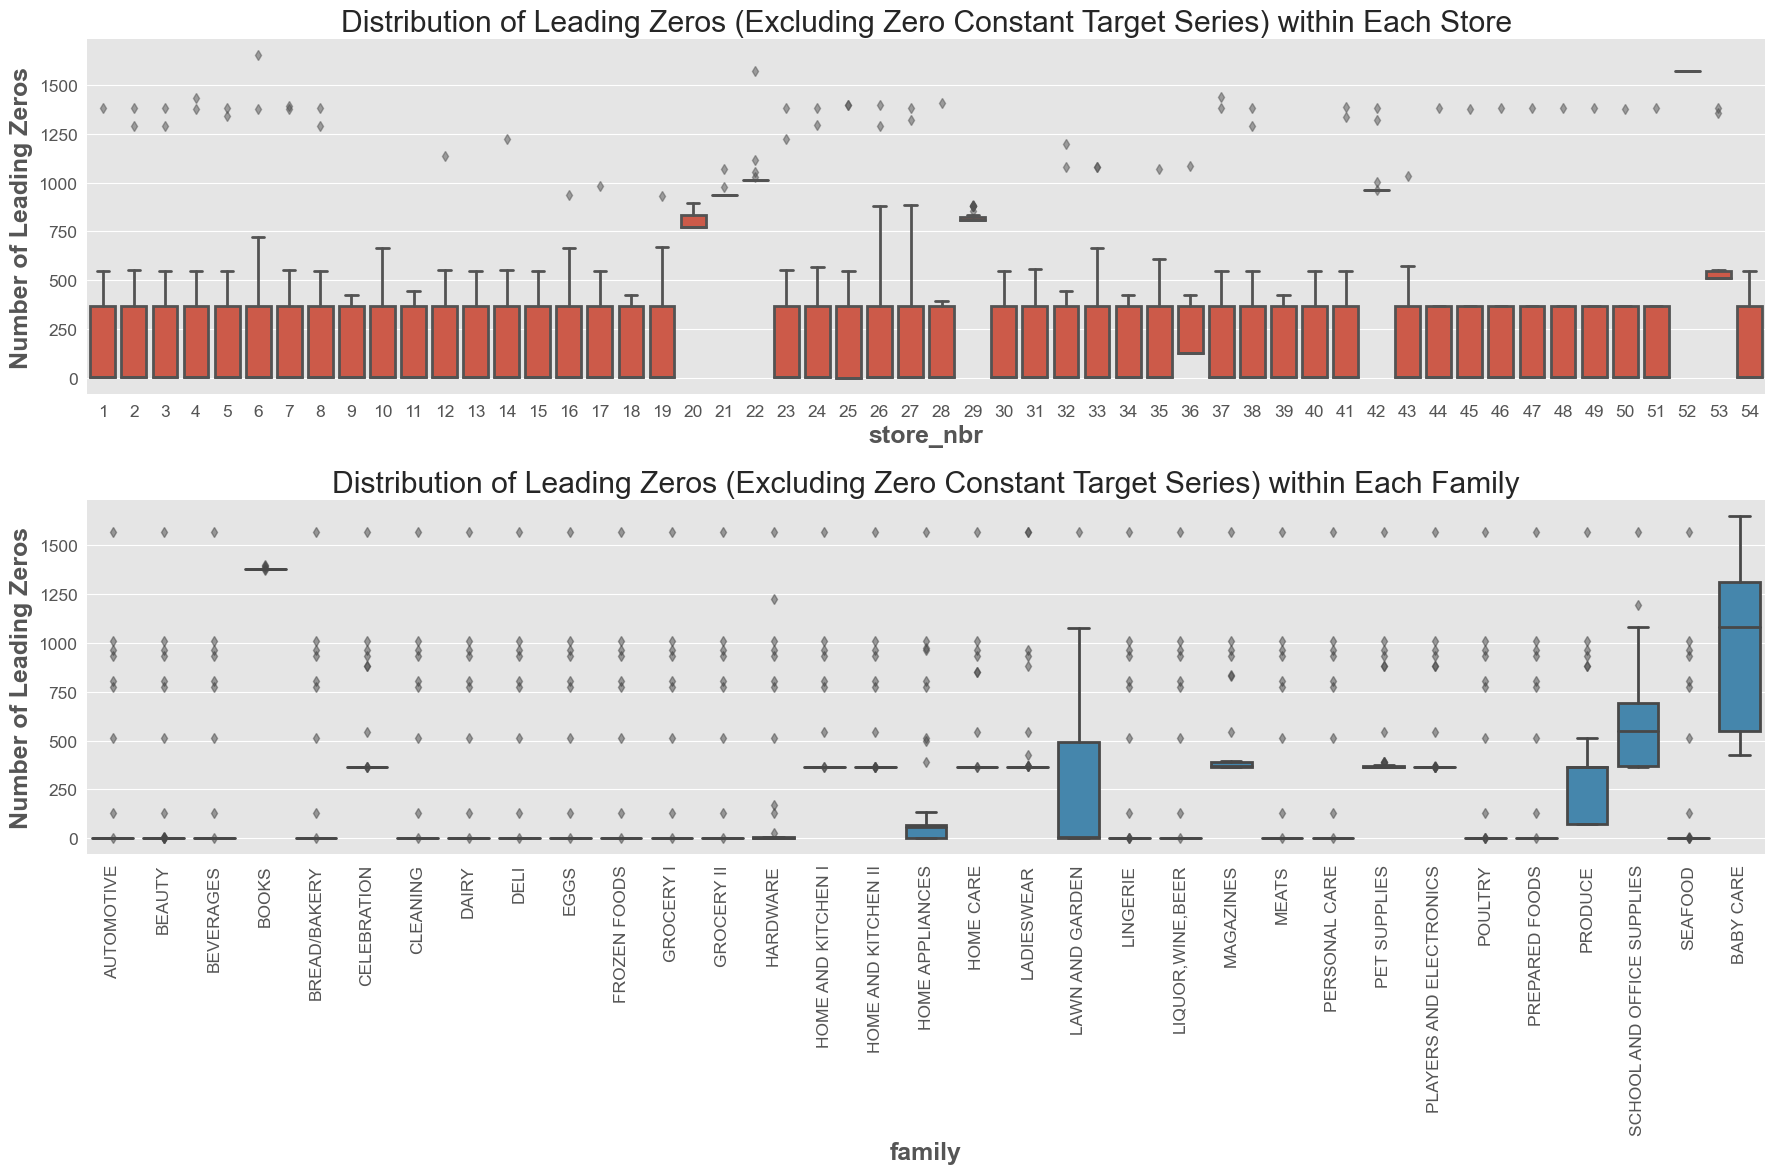

In [29]:
def count_leading_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return nonzero_idx[0]
    else:
        return len(x)

def plot_leading_zeros_distribution():
    leading_zeros = sales_ts.apply(count_leading_zeros).to_frame("num_leading_zeros").reset_index()
    leading_zeros = leading_zeros[leading_zeros.num_leading_zeros.lt(train_len)]

    cprint(
        "Time series with leading zeros (excluding zero constant target series)",
        f"Total number of time series                : {len(leading_zeros.index)}",
        f"Number of time series with >1 leading zeros: {leading_zeros.num_leading_zeros.gt(1).sum()}",
    )

    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }

    fig = plt.figure(figsize=(18, 12))

    ax0 = sns.boxplot(
        data=leading_zeros, x="store_nbr", y="num_leading_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=leading_zeros, x="family", y="num_leading_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Leading Zeros")
    plt.title("Distribution of Leading Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_leading_zeros_distribution()

Вывод: имеется несколько целевых рядов с завершающими нулями.
Мы также можем проверить количество конечных нулей в конце целевого ряда. Точно так же мы удаляем нулевой постоянный целевой ряд здесь. Не так много целевых серий с конечными нулями, что предполагает стабильные продажи на протяжении многих лет.

Однако наличие целевых рядов с сотнями конечных нулей может быть связано с низкими показателями продаж или с тем, что продукт больше не доступен ближе к концу. Примером может служить газон и сад. В этом случае создание нулевых прогнозов для таких целевых рядов было бы разумным подходом.

Target series with trailing zeros (excluding zero constant target series)
Total number of time series                : 1729
Number of target series with trailing zeros: 208


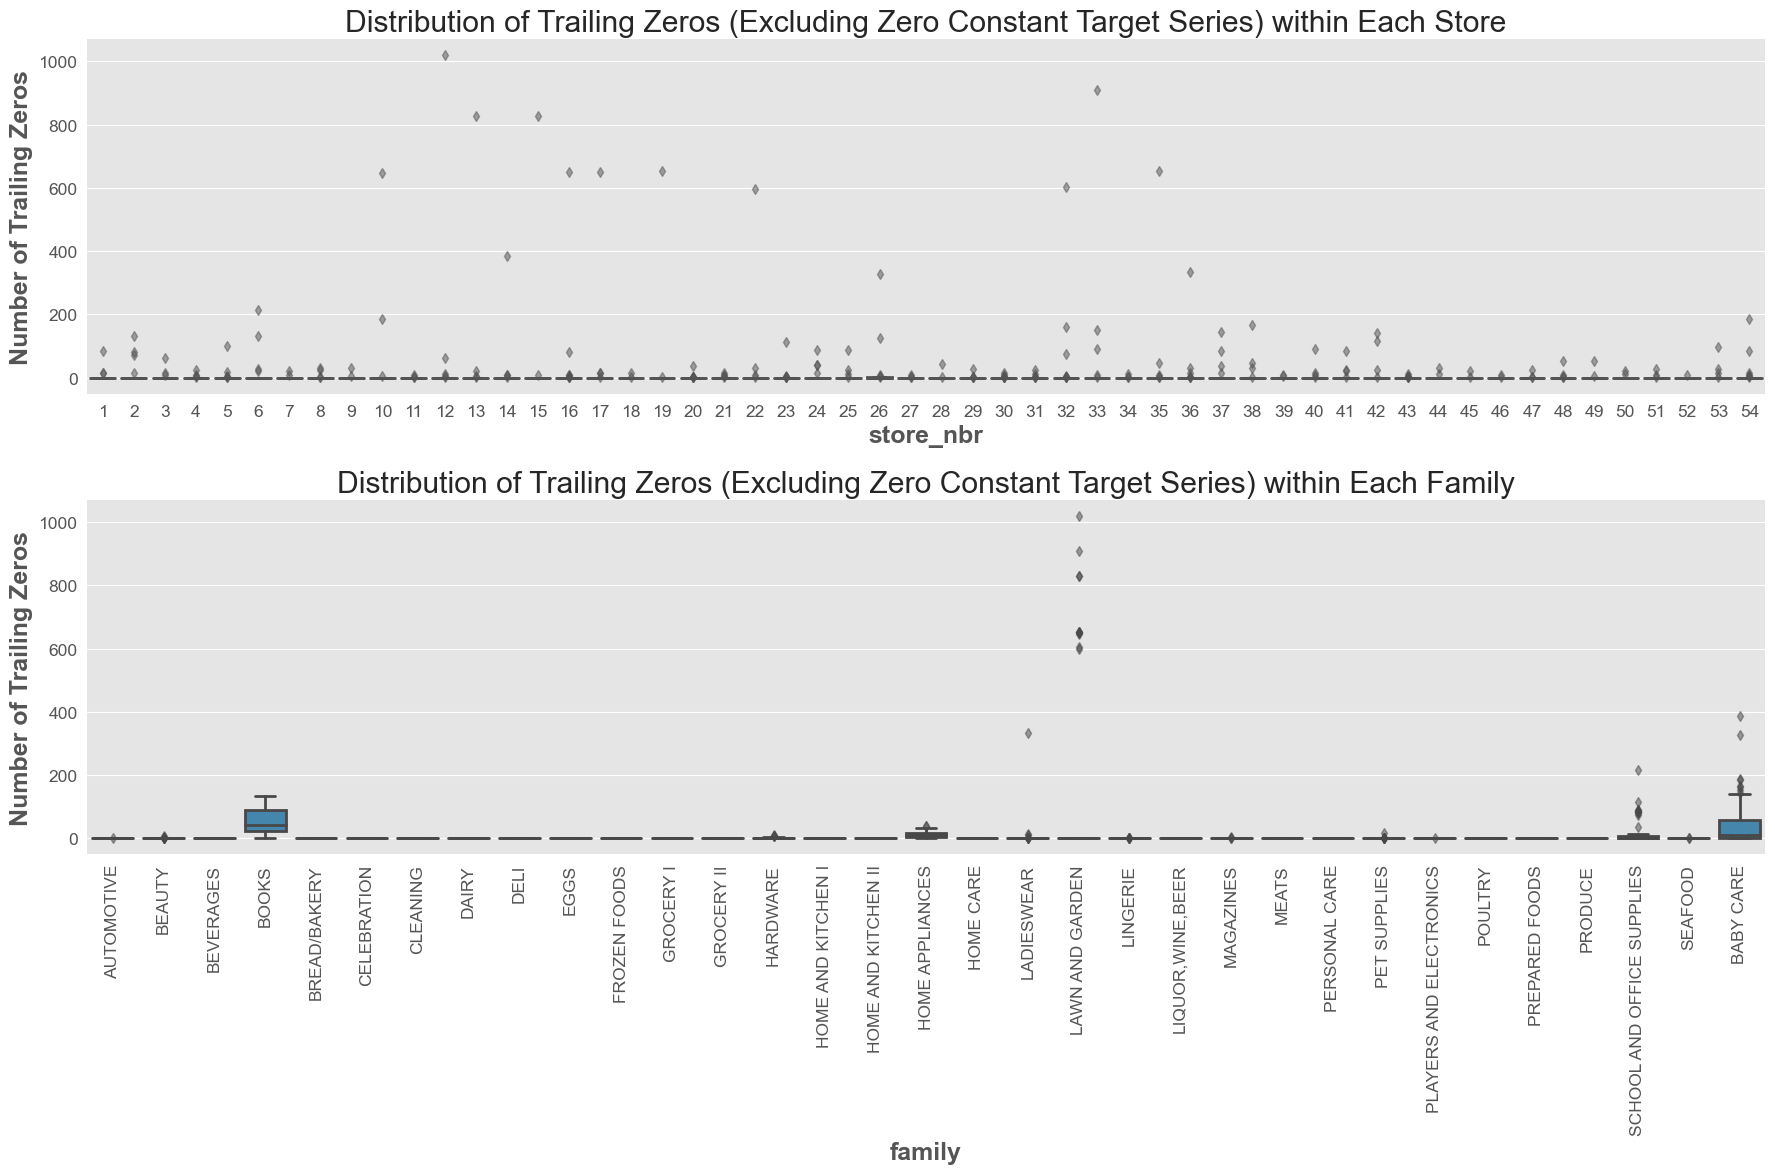

In [30]:
def count_trailing_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return len(x) - nonzero_idx[-1] - 1
    else:
        return len(x)

def plot_trailing_zeros_distribution():
    trailing_zeros = sales_ts.apply(count_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
    trailing_zeros = trailing_zeros[trailing_zeros.num_trailing_zeros.lt(train_len)]

    cprint(
        "Target series with trailing zeros (excluding zero constant target series)",
        f"Total number of time series                : {len(trailing_zeros.index)}",
        f"Number of target series with trailing zeros: {trailing_zeros.num_trailing_zeros.gt(0).sum()}",
    )

    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }

    fig = plt.figure(figsize=(18, 12))

    ax0 = sns.boxplot(
        data=trailing_zeros, x="store_nbr", y="num_trailing_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Store")

    ax1 = sns.boxplot(
        data=trailing_zeros, x="family", y="num_trailing_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Number of Trailing Zeros")
    plt.title("Distribution of Trailing Zeros (Excluding Zero Constant Target Series) within Each Family")

    plt.tight_layout()
    plt.show()

plot_trailing_zeros_distribution()

Вывод: средний объем продаж коррелирует с ценами на нефть, рекламными акциями и транзакциями в магазинах.
После анализа целевого ряда мы рассматриваем возможные ковариаты, чтобы улучшить наши модели. Столбец транзакций считается прошлым ковариантом, поскольку на момент прогнозирования известны только его прошлые значения. Чтобы спрогнозировать продажи на завтра, мы знаем только стоимость транзакций, которые произошли до сегодняшнего дня.

С другой стороны, столбцы oil и onpromotion являются ковариатами будущего, поскольку их текущие (и, возможно, будущие) значения известны на момент прогнозирования. Чтобы спрогнозировать продажи на завтра, у нас есть значения цен на нефть и значения продвижения на завтра. Это имеет смысл, потому что значения продвижения обычно устанавливаются заранее, чтобы стимулировать будущие продажи в магазине. Для нас необычно знать цены на нефть заранее, но, поскольку нам предоставлены данные, одно из возможных объяснений состоит в том, что мы используем оценки цен на нефть.

Как упоминалось ранее, столбцы транзакций и onpromotion будут масштабироваться перед вычислением средних значений. Средние продажи рассчитываются путем получения среднего значения по всем 1782 целевым рядам. Из графиков ниже мы видим, что:

Цены на нефть имеют отрицательную корреляцию со средним объемом продаж. Поскольку Эквадор является страной, зависящей от нефти, более высокие цены на нефть могут иметь инфляционные последствия, что приведет к снижению продаж в магазинах.
Значения рекламных акций положительно коррелируют со средним объемом продаж. Это просто, потому что с более постоянными рекламными акциями это привлекает человеческий трафик и, таким образом, способствует увеличению продаж. Еще одно интересное наблюдение заключается в том, что до начала 2014 года значение продвижения было нулевым.
Операции в магазине положительно коррелируют со средним объемом продаж. Продуктовые магазины состоят из множества семейств продуктов, которые дополняют друг друга, таких как птица, продукты и другие продукты питания. Имеет смысл, что если человек покупает немного мяса, он также с большей вероятностью купит овощи в качестве дополнения к сбалансированному питанию. Таким образом, продажи одного продукта могут повлиять на другой, поэтому магазины с более крупными сделками также должны иметь более высокие продажи для каждого семейства продуктов в целом.
Средние продажи имеют общую тенденцию к росту с резким снижением во время Рождества и Нового года, как объяснялось ранее. С более низкими ценами на нефть, более высокими значениями рекламных акций и более крупными транзакциями в магазинах это, по-видимому, поддерживает корреляцию со средними продажами, как объяснялось выше.

Covariates: oil, onpromotion, transactions
Past covariates  : transactions
Future covariates: oil, onpromotion


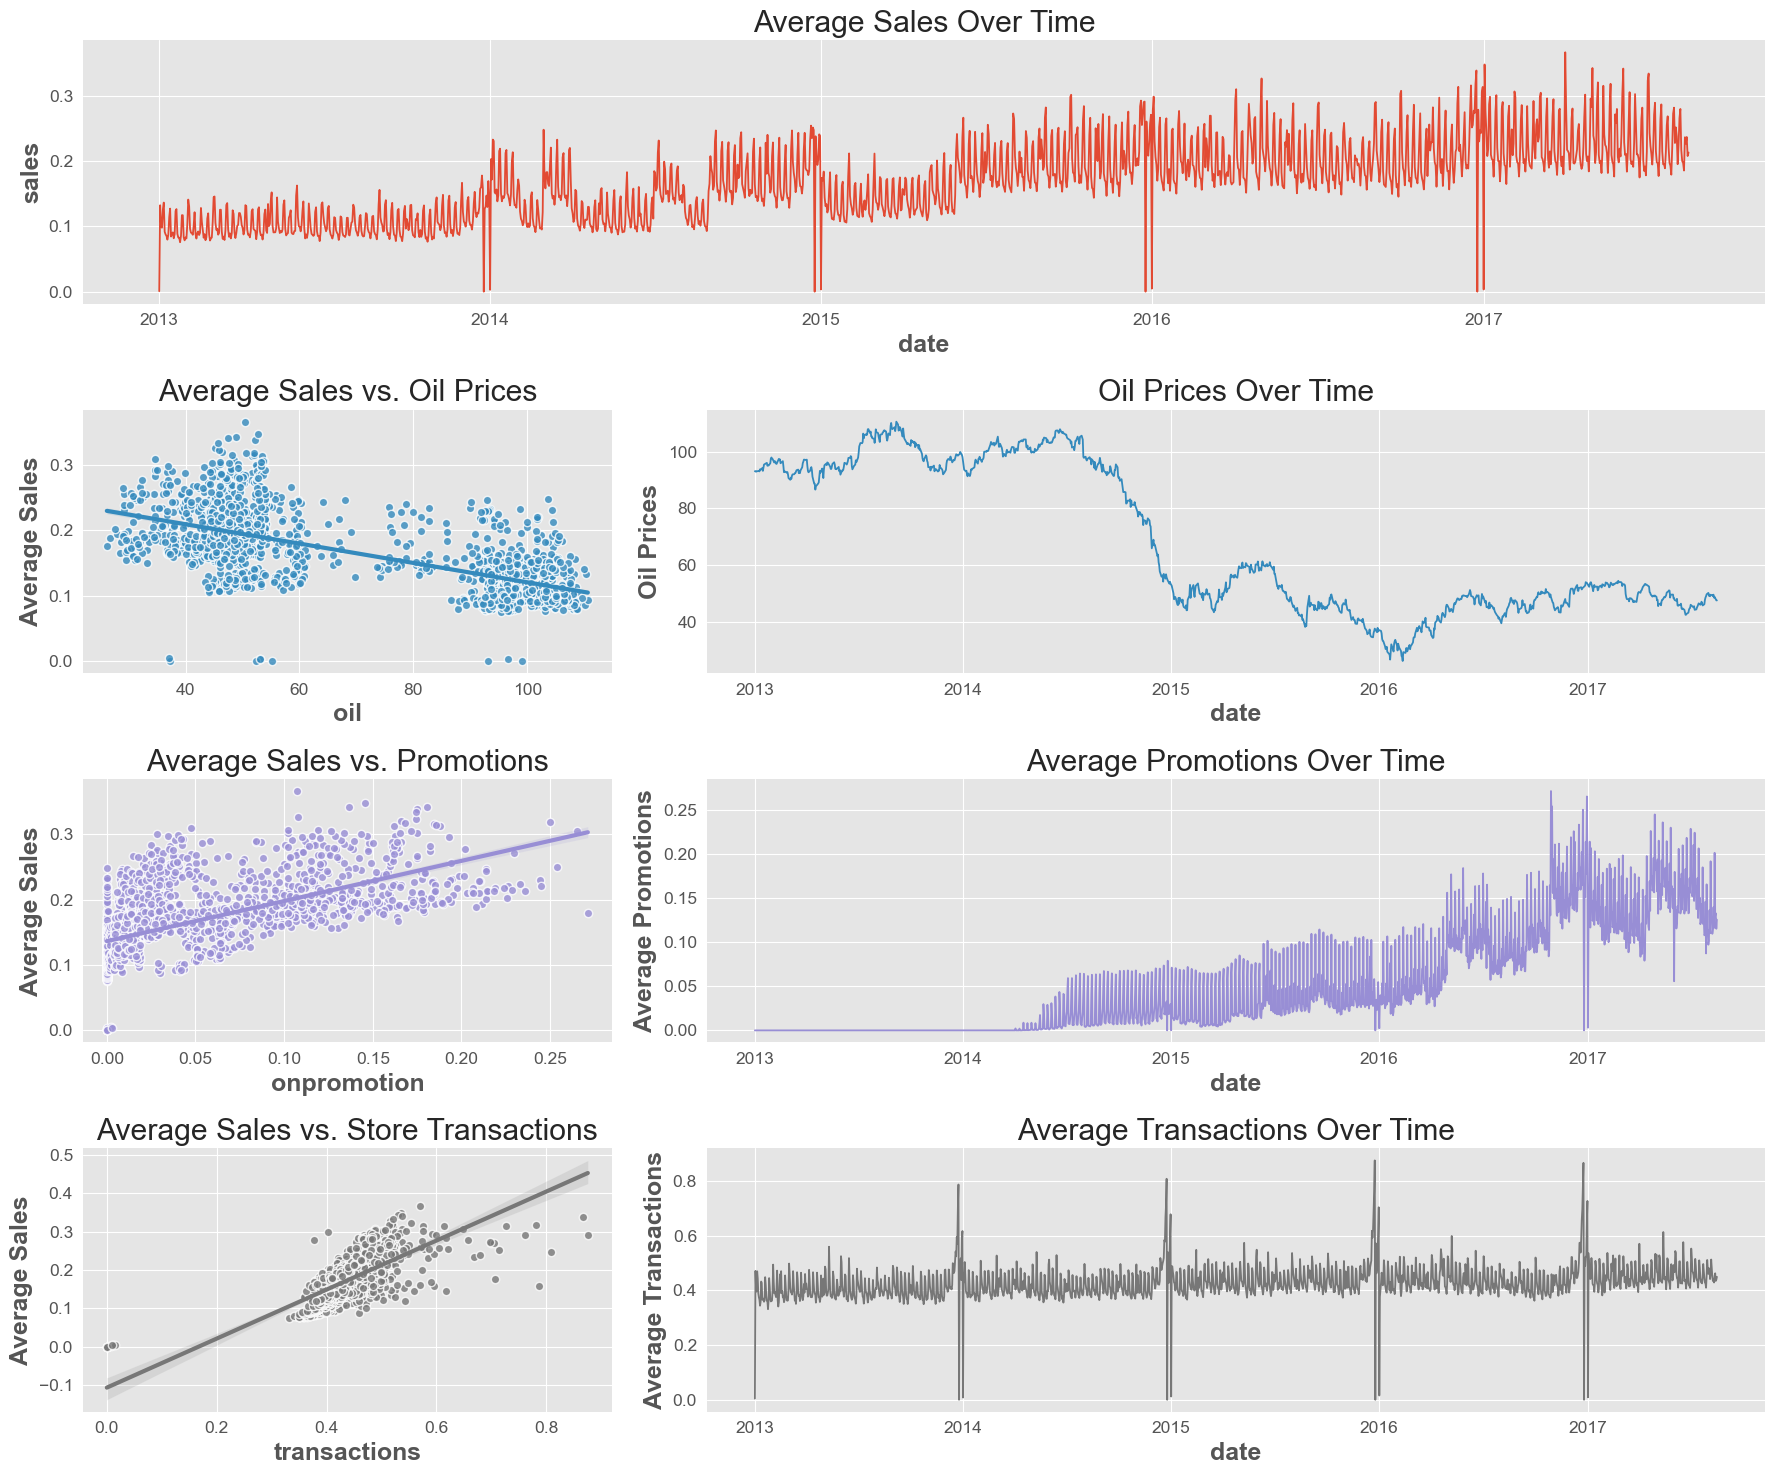

In [31]:
def plot_sales_correlation():
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)

    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()

    cprint(
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }

    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))

    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")

    sns.regplot(
        x=oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")

    sns.lineplot(
        data=oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")

    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")

    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()

plot_sales_correlation()

Вывод: в большинстве штатов есть магазины только в одном городе. В штатах с магазинами в нескольких городах обычно преобладает количество магазинов в одном городе.
Помимо прошлых и будущих ковариат, у нас также есть статические ковариаты, которые остаются постоянными во времени. Столбцы города и штата из данных магазина считаются статическими ковариатами, поскольку они представляют уникальные характеристики магазина и не меняются со временем. Другими примерами являются store_nbr и family, которые мы рассмотрели ранее.

На приведенной ниже линейчатой ​​диаграмме с накоплением указано количество магазинов в каждом штате, а единицы помечены соответствующими номерами магазинов. Они имеют цветовую кодировку каждого уникального города в штате. На примере Манаби магазин № 54 принадлежит одному городу, а магазины № 52, 53 — другому городу.

Мы видим, что в большинстве штатов есть только один цвет, а это означает, что магазины есть только в одном городе в каждом штате. В некоторых штатах, таких как Гуаяс и Пичинча, есть магазины в нескольких городах, но в магазинах преобладает один город. Другими словами, может не быть заметной разницы между влиянием на уровне города и штата на продажи в магазине, но это потребует некоторых экспериментов позже.

Static covariates: city, state
Number of unique cities                      : 22
Number of unique states                      : 16
Number of states with stores in only one city: 12


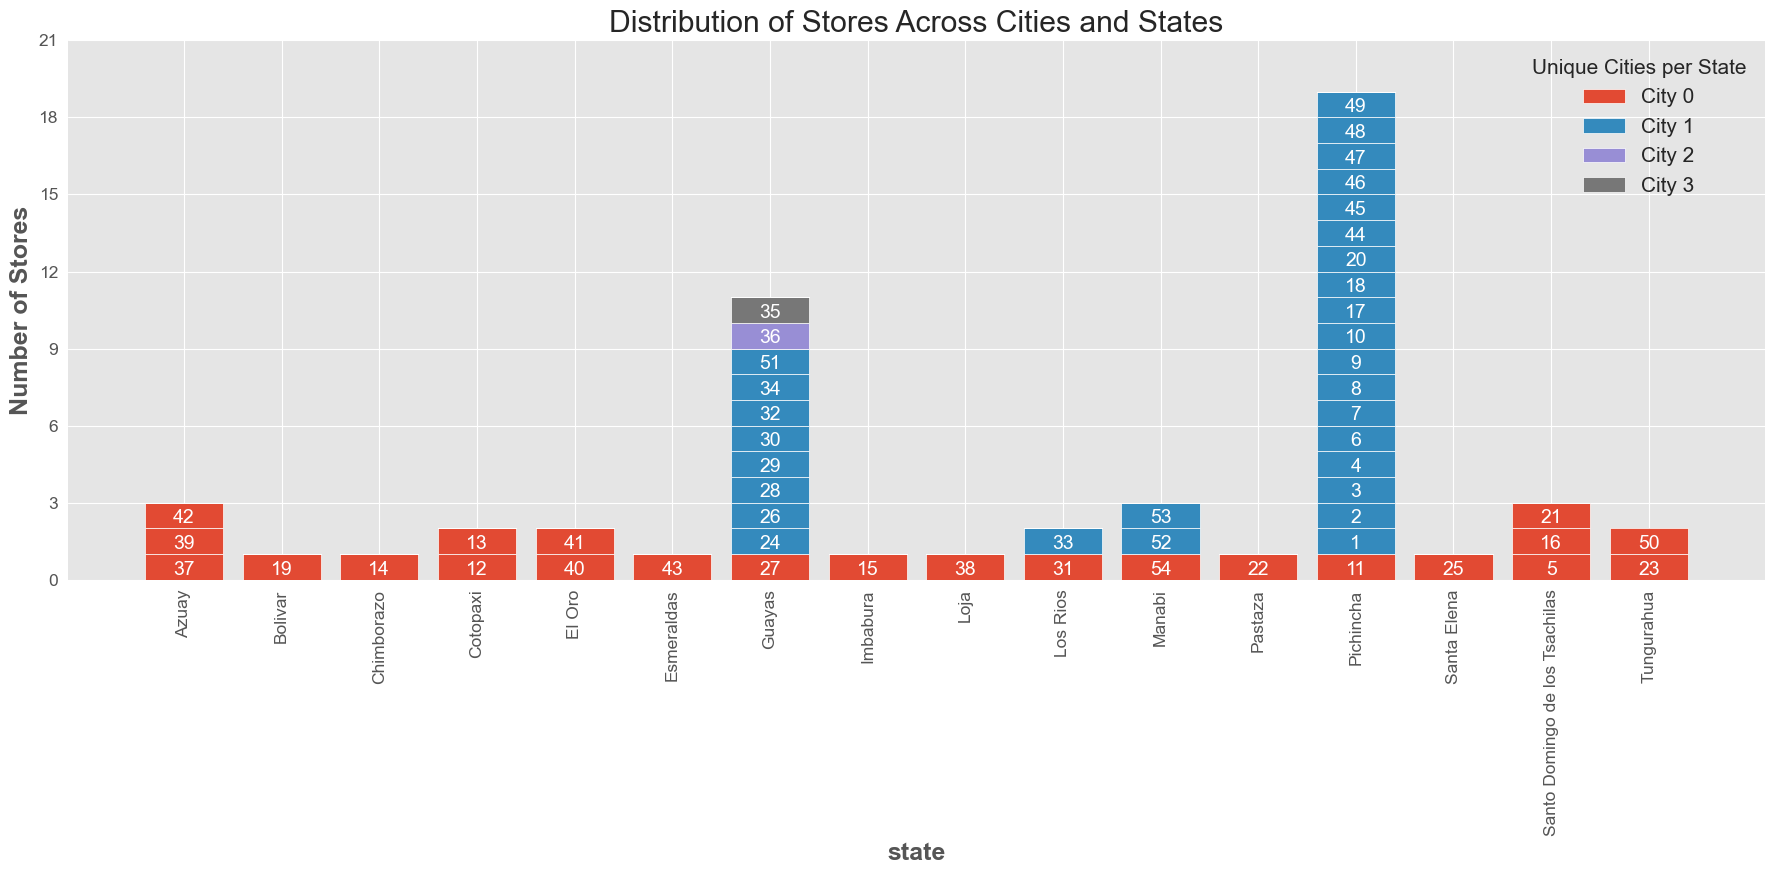

In [32]:
def plot_city_state_distribution(store):
    cprint(
        "Static covariates: city, state",
        f"Number of unique cities                      : {store.city.nunique()}",
        f"Number of unique states                      : {store.state.nunique()}",
        f"Number of states with stores in only one city: {(store.groupby('state').city.nunique().eq(1)).sum()}",
    )

    store = store.copy().sort_values(["state", "city", "store_nbr"])
    state_list = store.state.unique()
    bar_bottom = np.zeros(len(state_list))
    counter = {}

    fig = plt.figure(figsize=(18, 9))

    for num in store.store_nbr.unique():
        curr_state, curr_city = store.loc[store.store_nbr.eq(num), ["state", "city"]].values[0]
        if curr_state not in counter:
            counter[curr_state] = []
        if curr_city not in counter[curr_state]:
            counter[curr_state].append(curr_city)
        state_ind = (state_list==curr_state).astype(int)
        plt.bar(
            x=state_list, height=state_ind,
            bottom=bar_bottom,
            color=COLORS[len(counter[curr_state])-1],
            edgecolor="white",
            label=f"City {len(counter[curr_state])-1}",
        )
        bar_bottom += state_ind
        running_total = bar_bottom[np.argmax(state_ind)]
        plt.text(
            x=curr_state, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Unique Cities per State")
    plt.xticks(rotation=90)
    plt.yticks(list(range(0, 22, 3)))
    plt.xlabel("state")
    plt.ylabel("Number of Stores")
    plt.title("Distribution of Stores Across Cities and States")

    plt.tight_layout()
    plt.show()

plot_city_state_distribution(store)

Вывод: в каждом кластере доминирует один тип магазинов, а большинство типов магазинов имеют несколько кластеров.
Данные хранилища также содержат другие статические ковариаты, представленные столбцами типа и кластера. У нас есть еще одна гистограмма с накоплением, которая обозначает количество магазинов в каждом кластере, а единицы помечены соответствующими номерами магазинов. В этом случае единицы имеют цветовую маркировку в зависимости от типа магазина, к которому они принадлежат. Например, магазины в кластерах 1, 2, 4, 8, 9, 13 относятся к одному типу.

Поскольку большинство кластеров имеют только один цвет, в каждом из них доминирует один тип магазина. С другой стороны, большинство типов магазинов существуют в нескольких кластерах. Это повышает вероятность эффектов на уровне кластера и типа.

Static covariates: cluster, type
Number of unique store cluster: 17
Number of unique store type   : 5


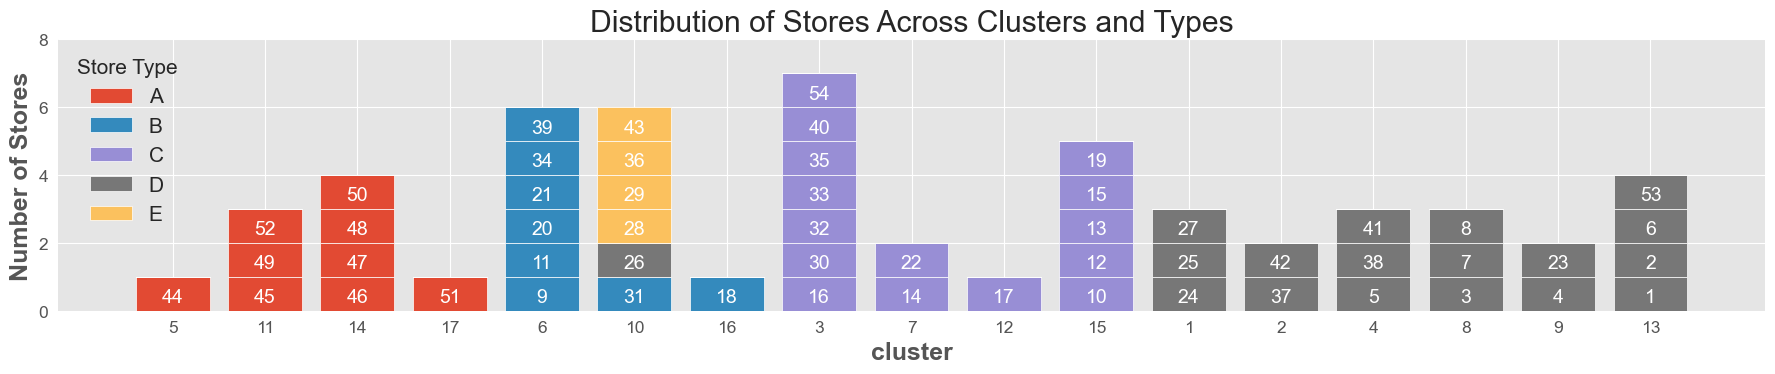

In [33]:
def plot_cluster_type_distribution(store):
    cprint(
        "Static covariates: cluster, type",
        f"Number of unique store cluster: {store.cluster.nunique()}",
        f"Number of unique store type   : {store.type.nunique()}",
    )
    store = store.copy().sort_values(["type", "cluster"])
    cluster_list = store.cluster.unique().astype(str)
    type_list = store.type.sort_values().unique()
    bar_bottom = np.zeros(len(cluster_list))
    color_map = {s_type: c for s_type, c in zip(type_list, COLORS)}

    fig = plt.figure(figsize=(18, 4))

    for num in store.store_nbr.unique():
        curr_cluster, curr_type = store.loc[store.store_nbr.eq(num), ["cluster", "type"]].astype(str).values[0]
        cluster_ind = (cluster_list==curr_cluster).astype(int)
        plt.bar(
            x=cluster_list, height=cluster_ind,
            bottom=bar_bottom,
            zorder=2,
            color=color_map[curr_type],
            label=curr_type,
            edgecolor="white",
        )
        bar_bottom += cluster_ind
        running_total = bar_bottom[np.argmax(cluster_ind)]
        plt.text(
            x=curr_cluster, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Store Type")
    plt.xlabel("cluster")
    plt.ylabel("Number of Stores")
    plt.yticks(list(range(0, 9, 2)))
    plt.title("Distribution of Stores Across Clusters and Types")

    plt.tight_layout()
    plt.show()

plot_cluster_type_distribution(store)

Вывод: некоторые национальные праздники/события, такие как День труда, Рождество и землетрясение 2016 года, оказывают большее влияние на продажи.
Праздники/события являются будущими ковариатами, поскольку даты обычно известны заранее. Для простоты мы будем использовать термин «праздник» для обозначения праздников и событий в этом блокноте. Как упоминалось ранее, нам нужно сравнить продажи в праздничные и непраздничные периоды. Глядя на приведенные ниже диаграммы для каждого праздника, мы отмечаем, что некоторые из них оказывают большее влияние на продажи. Примерами являются День труда (dia trabago), Рождество (navidad) и землетрясение 2016 года (terremoto). Нам нужно выбрать наиболее полезные из них, чтобы включить их в наши модели позже.

Future covariate: national holidays
Number of unique national holidays: 15


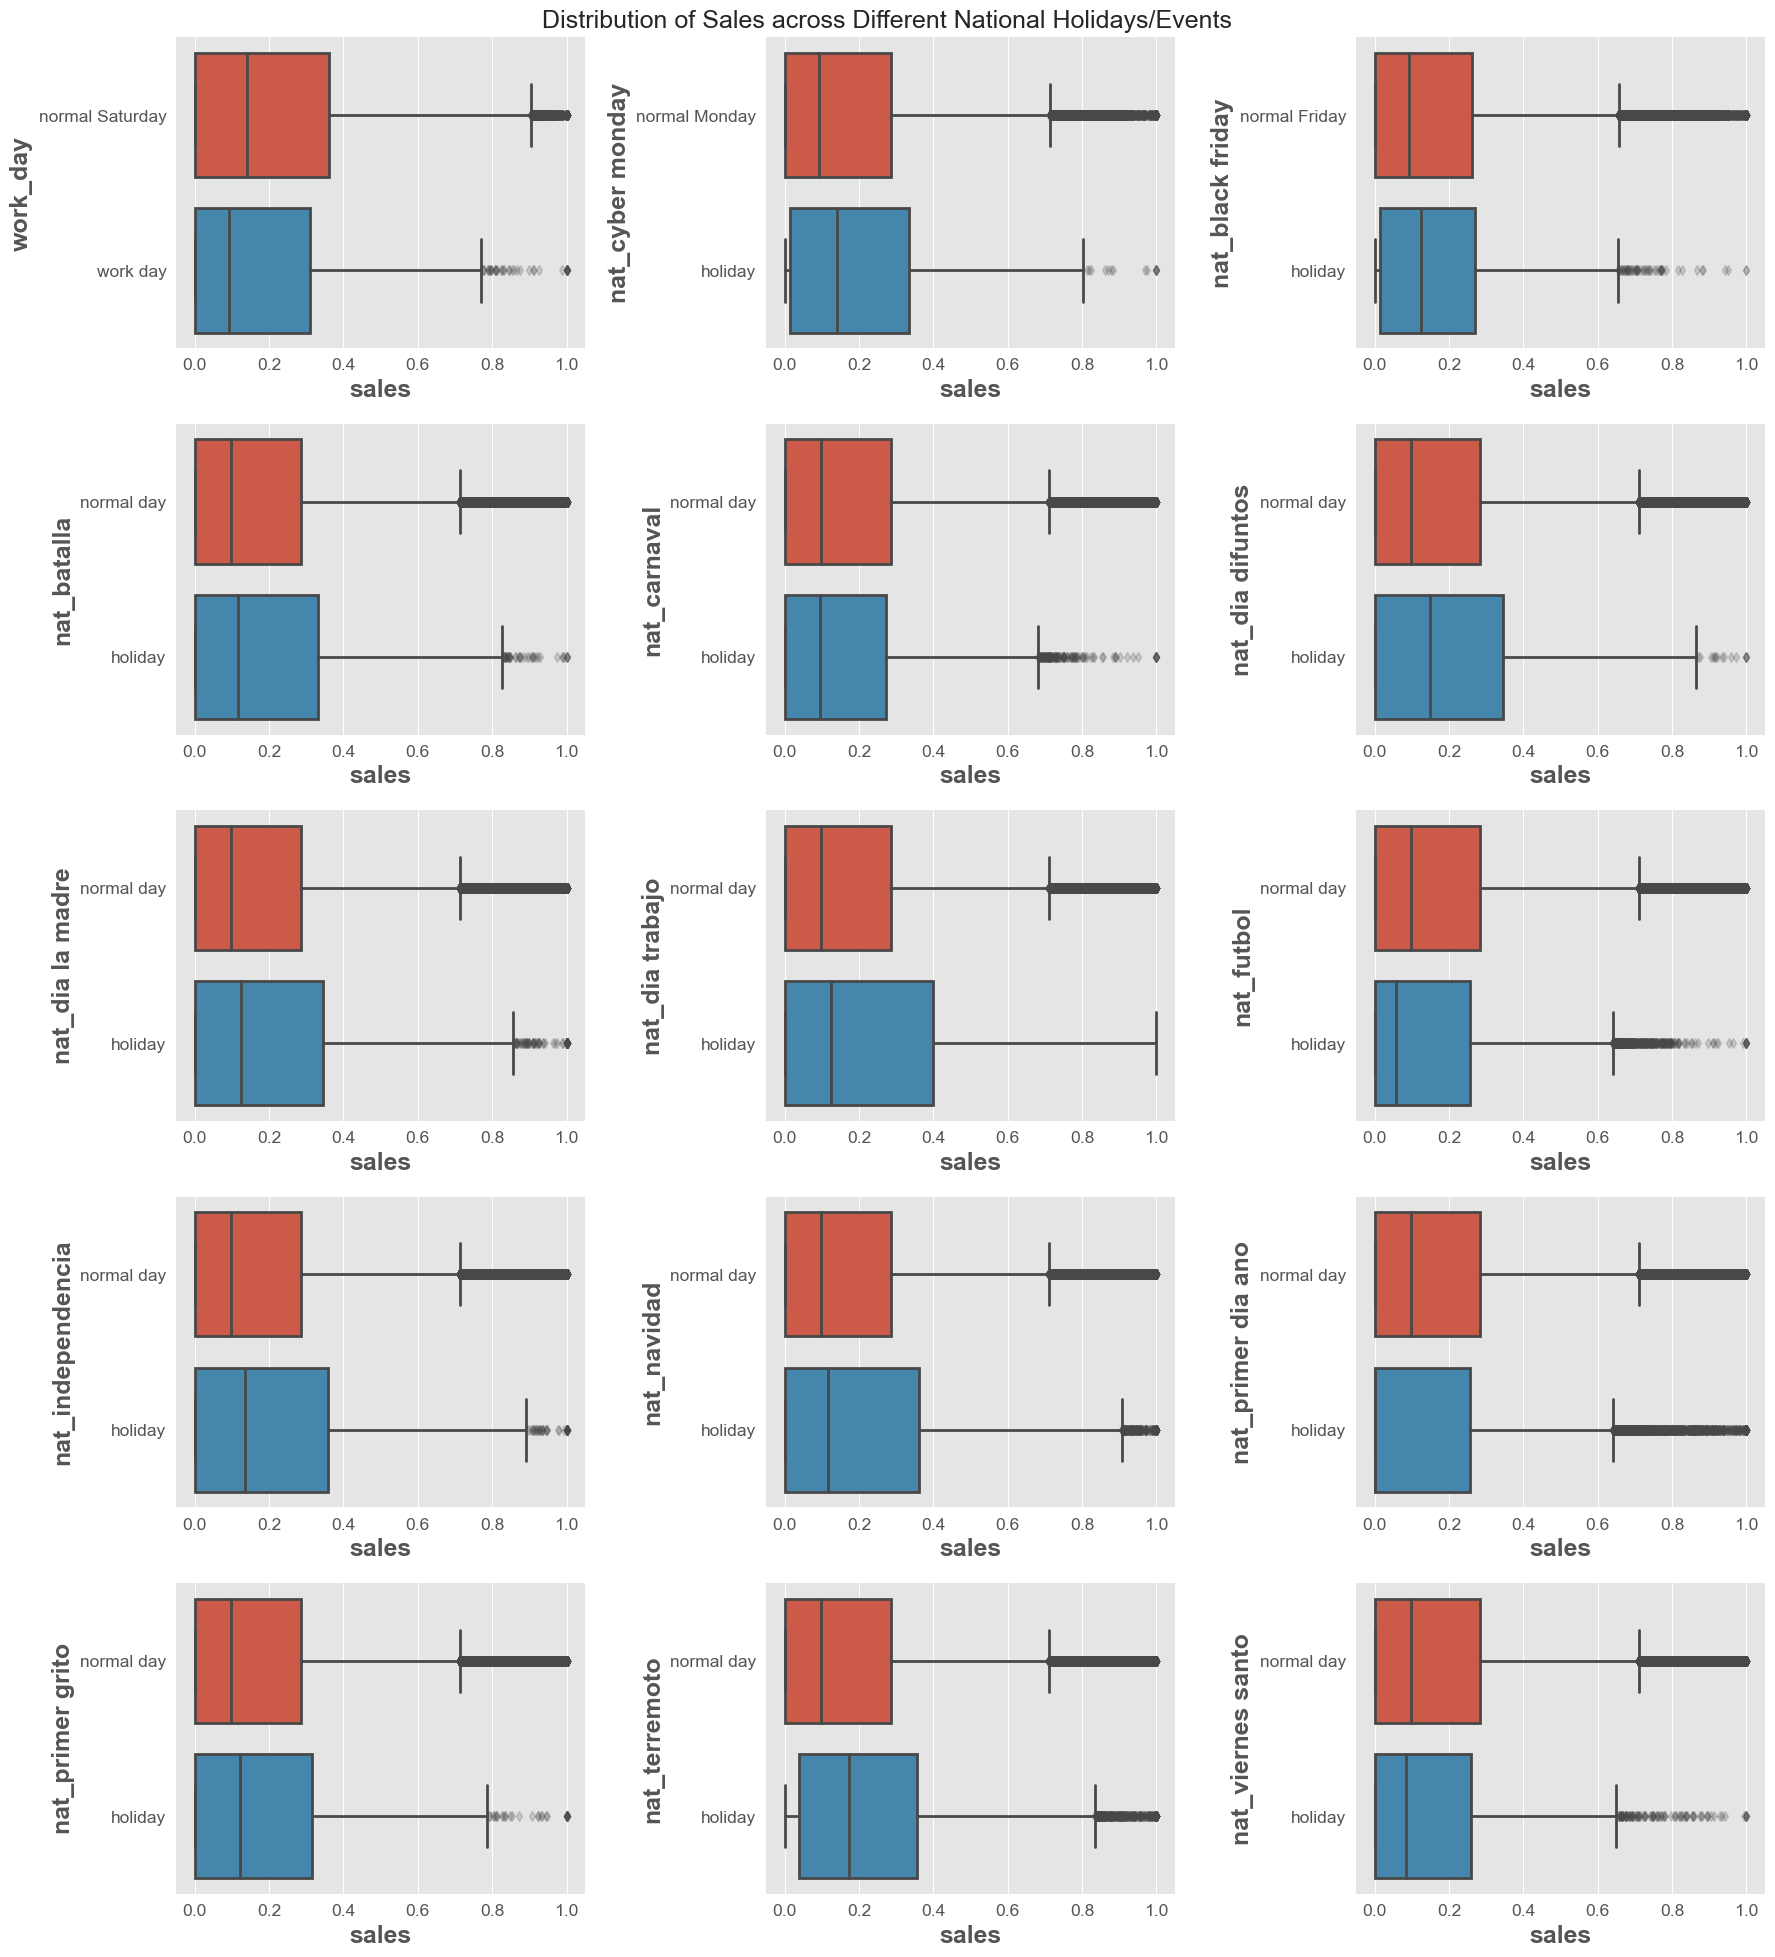

In [34]:
def plot_national_holiday_distribution():
    df = holiday_sales_merged.copy()
    holiday_list = national_holidays.columns[1:]

    cprint(
        "Future covariate: national holidays",
        f"Number of unique national holidays: {len(holiday_list)+1}"
    )

    plot_kwargs = {
        "palette": COLORS[:2],
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }

    fig = plt.figure(figsize=(18, 20))

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(5)) & (df.no_holiday.eq(1))],
        y="work_day",
        x="sales",
        ax=fig.add_subplot(531),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Saturday", "work day"])

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(0))],
        y="nat_cyber monday",
        x="sales",
        ax=fig.add_subplot(532),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Monday", "holiday"])

    sns.boxplot(
        data=df[(df.date.dt.weekday.eq(4))],
        y="nat_black friday",
        x="sales",
        ax=fig.add_subplot(533),
        **plot_kwargs,
    )
    plt.yticks([0, 1], ["normal Friday", "holiday"])

    for j, hol in enumerate(holiday_list.drop(["nat_cyber monday", "nat_black friday"])):
        sns.boxplot(
            data=df[(df[hol].eq(1)) | (df.no_holiday.eq(1))],
            y=hol,
            x="sales",
            ax=fig.add_subplot(5, 3, j+4),
            **plot_kwargs,
        )
        plt.yticks([0, 1], ["normal day", "holiday"])

    plt.suptitle("Distribution of Sales across Different National Holidays/Events")
    plt.tight_layout()
    plt.show()

plot_national_holiday_distribution()

Вывод: региональные и местные праздники оказывают меньшее влияние на продажи по сравнению с национальными праздниками.
Аналогичным образом мы исследуем влияние региональных и местных праздников, используя приведенные ниже диаграммы. Большинство коробчатых диаграмм между праздничными и непраздничными периодами выглядят довольно похоже, что позволяет предположить, что региональные и местные праздники не оказывают такого большого влияния на продажи. Это разумно, поскольку национальные праздники имеют более высокий уровень значимости и, следовательно, отмечаются более широко.

Future covariate: regional holidays
Total number of states                 : 16
Number of states with regional holidays: 4
Number of unique regional holidays     : 1


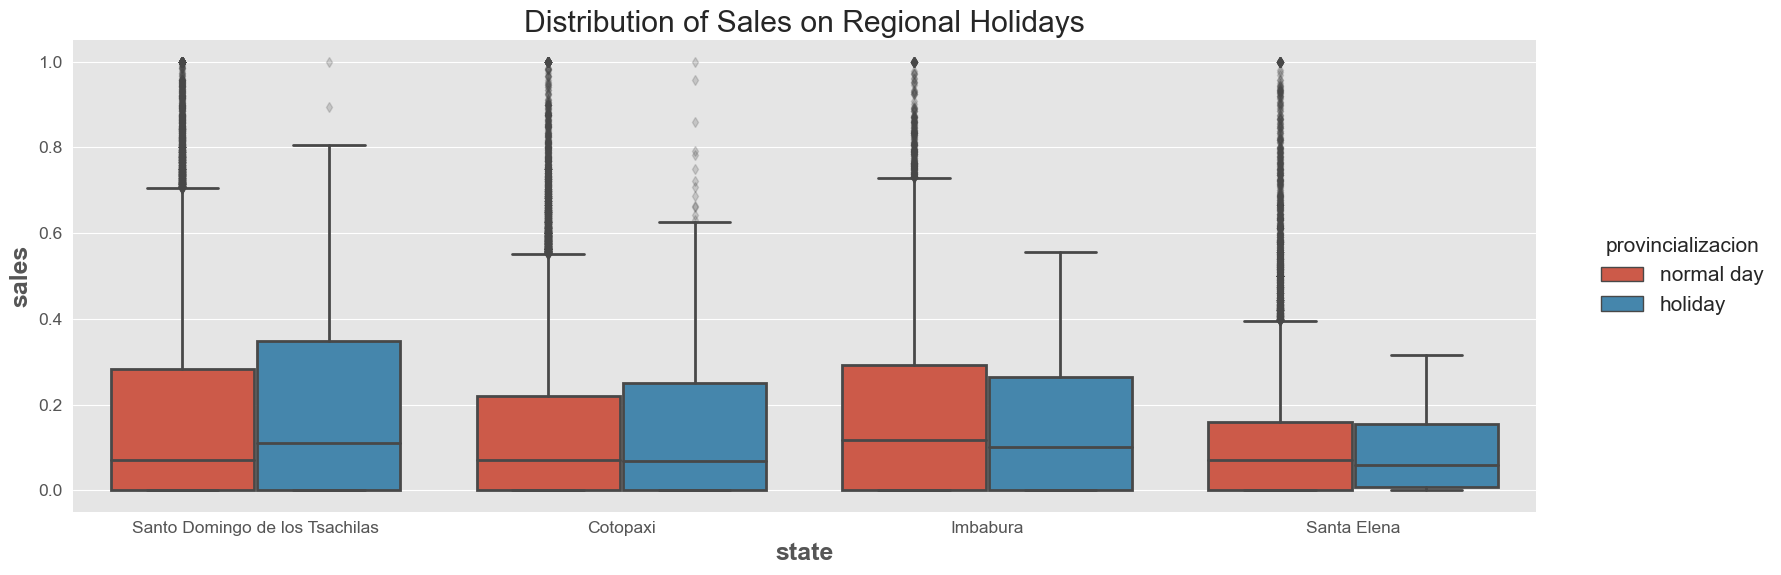

In [35]:
def plot_regional_holiday_distribution():
    df = holiday_sales_merged.copy()
    states_with_regional_holiday = regional_holidays.state.unique()
    df = df[df.state.isin(states_with_regional_holiday)]

    cprint(
        "Future covariate: regional holidays",
        f"Total number of states                 : {store.state.nunique()}",
        f"Number of states with regional holidays: {len(states_with_regional_holiday)}",
        "Number of unique regional holidays     : 1",
    )

    fig = plt.figure(figsize=(18, 6))

    sns.boxplot(
        data=df[(df.provincializacion.eq(1)) | (df.no_holiday.eq(1))],
        x="state",
        y="sales",
        hue="provincializacion",
        palette=COLORS[:2],
        linewidth=2,
        flierprops={"alpha": 0.2},
        ax=fig.add_subplot(111),
    )
    plt.title("Distribution of Sales on Regional Holidays")
    leg = plt.legend(loc="center", title="provincializacion", bbox_to_anchor=(1.1, 0.5))
    leg.texts[0].set_text("normal day")
    leg.texts[1].set_text("holiday")

    plt.tight_layout()
    plt.show()

plot_regional_holiday_distribution()

Future covariate: local holidays
Total number of cities              : 22
Number of cities with local holidays: 19
Number of unique local holidays     : 3


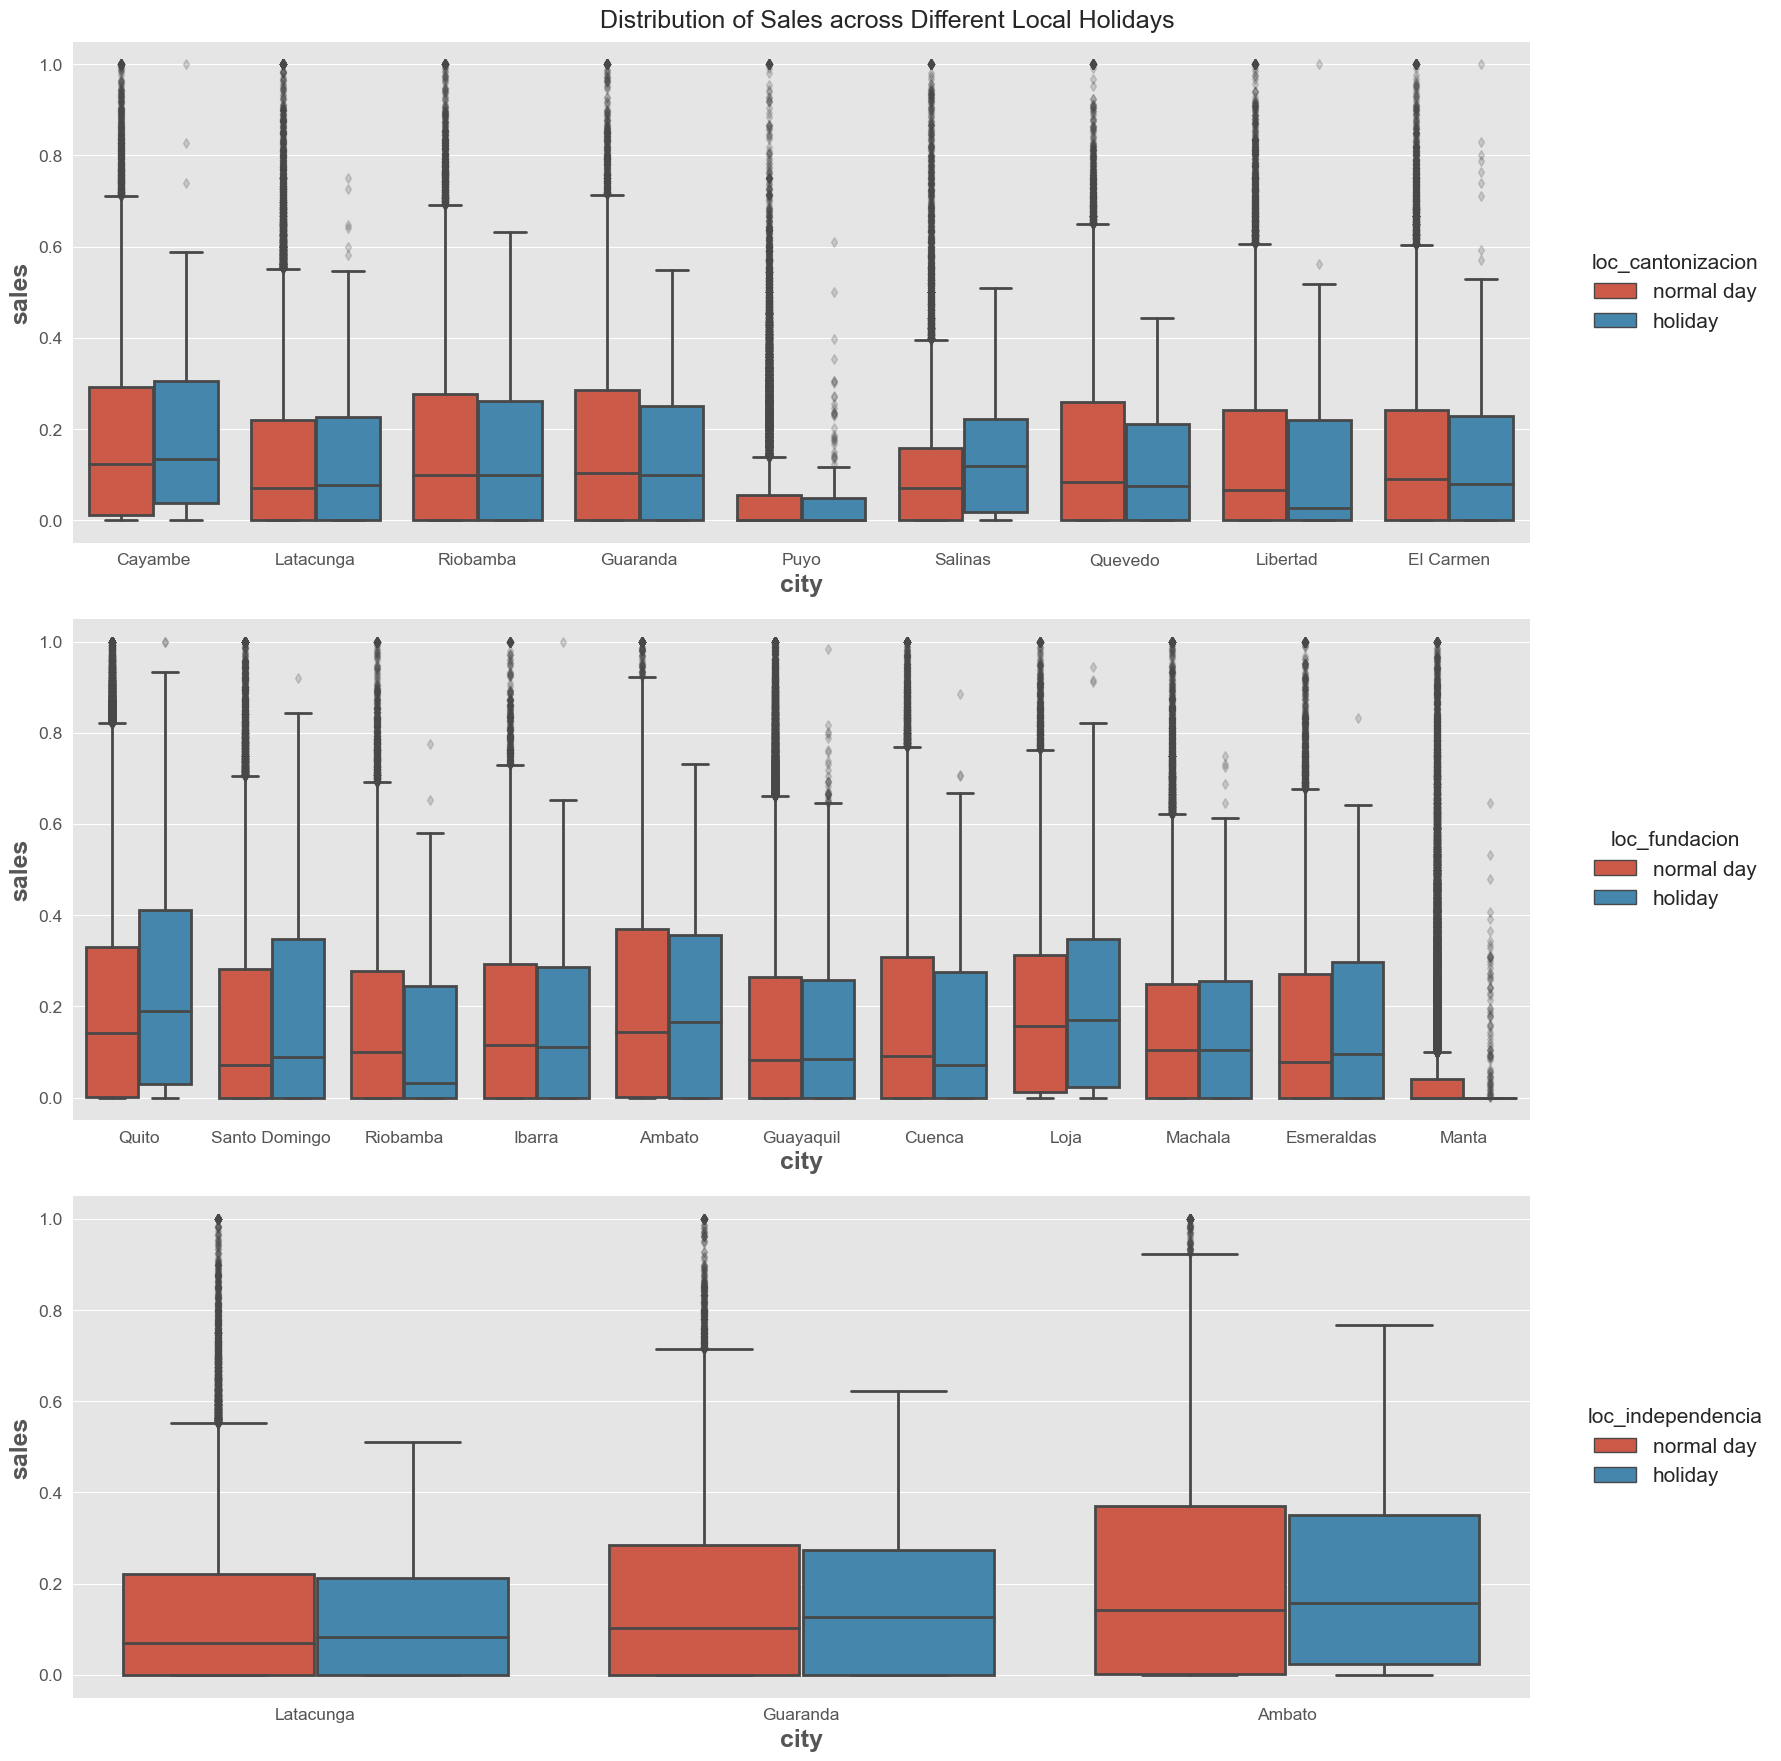

In [36]:
def plot_local_holiday_distribution():
    df = holiday_sales_merged.copy()
    holiday_list = local_holidays.columns[2:]

    cprint(
        "Future covariate: local holidays",
        f"Total number of cities              : {store.city.nunique()}",
        f"Number of cities with local holidays: {local_holidays.city.nunique()}",
        f"Number of unique local holidays     : {len(holiday_list)}",
    )

    fig = plt.figure(figsize=(18, 18))

    for j, hol in enumerate(holiday_list):
        tmp = df[df.city.isin(local_holidays[local_holidays[hol].eq(1)].city.unique())]
        sns.boxplot(
            data=tmp[(tmp[hol].eq(1)) | (tmp.no_holiday.eq(1))],
            x="city",
            y="sales",
            hue=hol,
            palette=COLORS[:2],
            linewidth=2,
            flierprops={"alpha": 0.2},
            ax=fig.add_subplot(3, 1, j+1),
        )
        leg = plt.legend(loc="center", title=hol, bbox_to_anchor=(1.1, 0.5))
        leg.texts[0].set_text("normal day")
        leg.texts[1].set_text("holiday")

    plt.suptitle("Distribution of Sales across Different Local Holidays")
    plt.tight_layout()
    plt.show()

plot_local_holiday_distribution()

Вывод: модели продаж можно отразить с помощью функций, связанных с датами.
Функции, связанные с датой, такие как месяц и год каждой точки данных, считаются будущими ковариатами, поскольку они фиксированы и, следовательно, известны заранее. Чтобы предотвратить влияние праздников, мы обязательно фильтруем данные, чтобы включать только непраздничные периоды. Мы попытаемся рассмотреть распределение продаж по каждой ковариате с помощью коробчатых диаграмм. Некоторые ковариаты, такие как дни года, имеют очень большое количество категорий (365–366 дней в году), поэтому проверка многих коробочных диаграмм может оказаться неправдоподобной. В таких случаях мы просто вычисляем средний объем продаж (по всем целевым рядам) за каждый период времени. Создаются следующие функции, связанные с датами:

день. Поскольку дни зарплаты приходятся на 15-й и последний день месяца, мы видим, что продажи имеют тенденцию сильнее различаться в одни и те же периоды. В частности, это более заметно в конце/начале месяца.
месяц. Хотя большинство коробочных сюжетов выглядят одинаково, продажи в декабре, как правило, сильно различаются. Это может быть сезонная закономерность, когда люди заранее готовятся к Рождеству или Новому году.
год. Из диаграмм видно, что продажи имеют общую тенденцию к росту в течение года.
день недели. Продажи, как правило, выше в выходные дни, которые для большинства людей являются нерабочими днями. Разумно сказать, что у них появляется больше времени на посещение продуктовых магазинов, что приводит к увеличению продаж.
день_года / неделя_года. Дни года и недели года дают информацию, аналогичную месяцам, но с разной степенью детализации. Например, продажи в первую неделю, как правило, большие, а в первый день года продажи очень малы.
дата_индекс. Индекс даты (индекс целевого ряда) дает информацию, аналогичную годам, но с более высоким уровнем детализации. В первой половине периода наблюдаются более значительные колебания.

Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index
day                     : paydays on the 15th and last day of the month
month                   : monthly seasonal patterns
year                    : general trends
day_of_week             : weekdays vs. weekends
day_of_year/week_of_year: different levels of granularity from month
date_index              : higher level of granularity than year


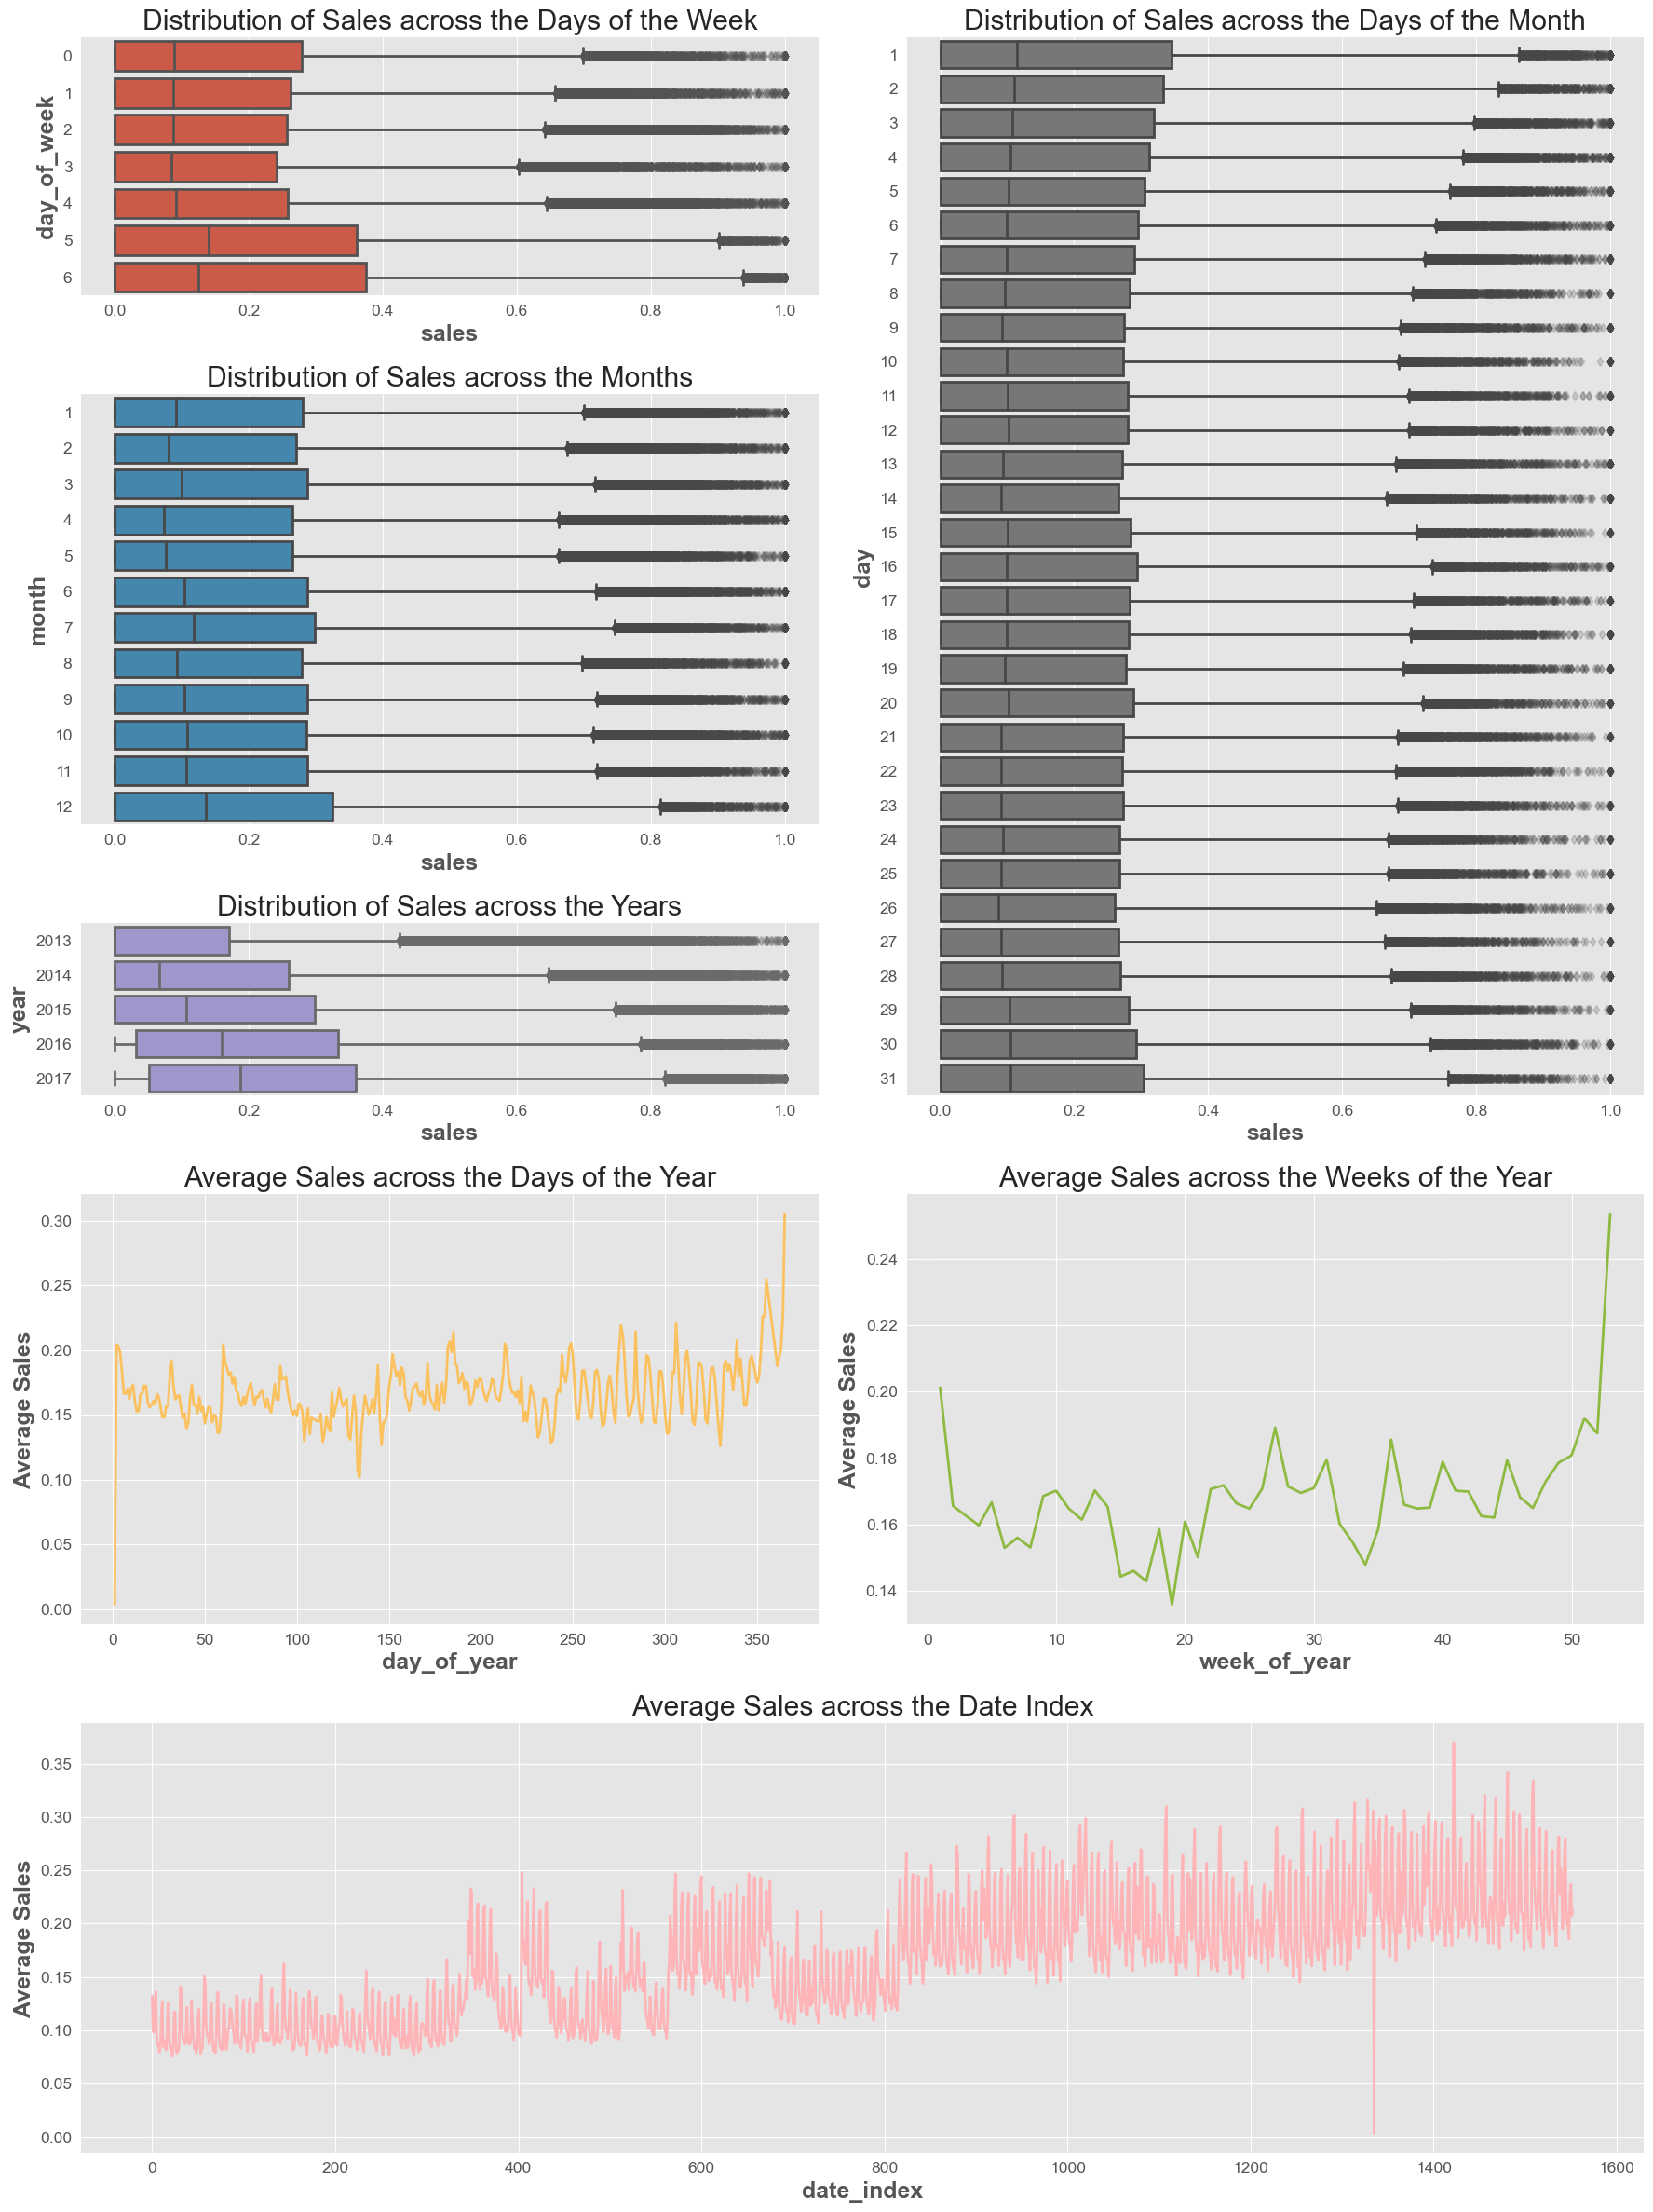

In [37]:
def plot_date_distribution():
    df = holiday_sales_merged.copy().sort_values(["date", "store_nbr", "family"], ignore_index=True)
    df = df[df.no_holiday.eq(1)].reset_index(drop=True)
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["day_of_week"] = df.date.dt.dayofweek
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.date.factorize()[0]

    cprint(
        "Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index",
        "day                     : paydays on the 15th and last day of the month",
        "month                   : monthly seasonal patterns",
        "year                    : general trends",
        "day_of_week             : weekdays vs. weekends",
        "day_of_year/week_of_year: different levels of granularity from month",
        "date_index              : higher level of granularity than year",
    )

    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }

    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))

    sns.boxplot(
        data=df,
        y="day_of_week",
        x="sales",
        color=COLORS[0],
        ax=fig.add_subplot(gs[0, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Week")

    sns.boxplot(
        data=df,
        y="month",
        x="sales",
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Months")

    sns.boxplot(
        data=df,
        y="year",
        x="sales",
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Years")

    sns.boxplot(
        data=df,
        y="day",
        x="sales",
        color=COLORS[3],
        ax=fig.add_subplot(gs[:3, 1]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Month")

    sns.lineplot(
        data=df.groupby("day_of_year").sales.mean().reset_index(),
        x="day_of_year",
        y="sales",
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Days of the Year")

    sns.lineplot(
        data=df.groupby("week_of_year").sales.mean().reset_index(),
        x="week_of_year",
        y="sales",
        color=COLORS[5],
        ax=fig.add_subplot(gs[3, 1]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Weeks of the Year")

    sns.lineplot(
        data=df.groupby("date_index").sales.mean().reset_index(),
        x="date_index",
        y="sales",
        color=COLORS[6],
        ax=fig.add_subplot(gs[4, :]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Date Index")

    plt.tight_layout()
    plt.show()

plot_date_distribution()

3. Модельное обучение
Объединение наборов данных.
Теперь, когда мы закончили анализ, приступаем к обучению наших моделей прогнозированию. Чтобы подготовить наши данные для обучения, нам необходимо объединить соответствующие наборы данных и включить полезные ковариаты, как обсуждалось ранее. Предпринятые шаги описаны в приведенном ниже коде.

Дополнительный шаг, выполняемый здесь, заключается в том, что на Рождество и Новый год, когда в большинстве магазинов продажи нулевые (поскольку они, скорее всего, закрыты), вместо заполнения значений нулями мы временно устанавливаем их в NaN и позже выполняем линейную интерполяцию. Причина этого в том, что такие дни следует рассматривать как обычные праздники, а не включать дополнительную переменную, чтобы отразить это уникальное поведение закрытия магазина.

In [38]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


Определение конвейеров трансформации.
С этого момента мы начинаем изучать функциональные возможности библиотеки дартс для прогнозирования. Здесь мы определяем конвейеры преобразования, которые включают в себя:

MissingValuesFiller для заполнения пропущенных значений, таких как значения NaN, которые мы временно установили ранее. Поведение по умолчанию — линейная интерполяция.
StaticCovariatesTransformer для кодирования/масштабирования наших статических ковариат. Все наши статические ковариаты являются категориальными, поэтому мы указываем выполнение горячего кодирования с использованием OneHotEncoder из sklearn.
InvertibleMapper для определения специального преобразователя журналов для нашей целевой серии. Логарифмическое преобразование может помочь стабилизировать наш целевой ряд за счет уменьшения величины больших значений.
Scaler для масштабирования всех наших целевых рядов и ковариат. Поведение по умолчанию — масштабирование мин-макс.

In [39]:
def get_pipeline(static_covs_transform=False, log_transform=False):
    lst = []

    # fill missing values
    filler = MissingValuesFiller(n_jobs=-1)
    lst.append(filler)

    # specify transformation for static covariates
    if static_covs_transform:
        static_covs_transformer = StaticCovariatesTransformer(
            transformer_cat=OneHotEncoder(),
            n_jobs=-1,
        )
        lst.append(static_covs_transformer)

    # perform log transformation on sales
    if log_transform:
        log_transformer = InvertibleMapper(
            fn=np.log1p,
            inverse_fn=np.expm1,
            n_jobs=-1,
        )
        lst.append(log_transformer)

    # rescale time series
    scaler = Scaler()
    lst.append(scaler)

    # chain all transformations
    pipeline = Pipeline(lst)
    return pipeline

Извлечение целевого ряда вместе со статическими ковариатами.
Прежде чем мы преобразуем наши данные для прогнозирования с помощью дартс, необходимо определить тип моделей, которые мы будем использовать. Традиционные статистические модели, такие как ARIMA, ориентированы на прогнозирование одного целевого ряда для каждой модели. Поскольку у нас есть 1782 целевых ряда, построение 1782 моделей может оказаться дорогостоящим в вычислительном отношении. Именно здесь появляется концепция глобальных моделей, позволяющая одной модели прогнозировать несколько целевых рядов, используя общую информацию.

Для статических ковариат мы определили столбцы «город», «штат», «кластер», «тип», «store_nbr», «семейство». Поскольку мы группируем целевые серии по семействам продуктов, мы можем удалить столбец семейства.

In [40]:
def get_target_series(static_cols, log_transform=True):
    target_dict = {}
    pipe_dict = {}
    id_dict = {}

    for fam in tqdm_notebook(data.family.unique(), desc="Extracting target series"):
        # filter data for each model
        df = data[(data.family.eq(fam)) & (data.date.le(train_end.strftime("%Y-%m-%d")))]

        # initialize transformation pipeline for target series
        pipe = get_pipeline(True, log_transform=log_transform)

        # extract target series together with static covariates
        target = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols="sales",
            group_cols="store_nbr",
            static_cols=static_cols,
        )

        # record identity of each target series
        target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam}
                     for t in target]
        id_dict[fam] = target_id

        # apply transformations
        target = pipe.fit_transform(target)
        target_dict[fam] = [t.astype(np.float32) for t in target]
        pipe_dict[fam] = pipe[2:]

    return target_dict, pipe_dict, id_dict

In [41]:
# list of static covariates excluding 'store_nbr'; 'store_nbr' is automatically extracted using 'group_cols'
static_cols = ["city", "state", "type", "cluster"]

target_dict, pipe_dict, id_dict = get_target_series(static_cols)

Extracting target series:   0%|          | 0/33 [00:00<?, ?it/s]

Извлечение прошлых и будущих ковариат.
Для прошлых ковариатов у нас есть только столбец транзакций. Для будущих ковариат у нас есть столбцы «Нефть», «Продвижение», «Праздничные столбцы», а также столбцы, связанные с датами. Чтобы улучшить наши модели, мы можем извлечь дополнительные ковариаты, вычисляя скользящие средние данных наших временных рядов с помощью MovingAverageFilter. Это помогает сгладить шум и более эффективно уловить основные закономерности.

* Мы следуем справочному блокноту, чтобы использовать скользящие средние нефти и onpromotion с размерами окон 7, 28. Код ниже поддерживает вычисление скользящих средних только для прошлых и будущих ковариат. Чтобы включить скользящие средние продаж целевых серий, необходимо внести некоторые изменения.

In [42]:
def get_covariates(
        past_cols,
        future_cols,
        past_ma_cols=None,
        future_ma_cols=None,
        past_window_sizes=[7, 28],
        future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}

    # initialize transformation pipeline for covariates
    covs_pipe = get_pipeline()

    for fam in tqdm_notebook(data.family.unique(), desc="Extracting covariates"):
        # filter data for each model
        df = data[data.family.eq(fam)]

        # extract past covariates
        past_covs = TimeSeries.from_group_dataframe(
            df=df[df.date.le(train_end.strftime("%Y-%m-%d"))],
            time_col="date",
            value_cols=past_cols,
            group_cols="store_nbr",
        )
        past_covs = [p.with_static_covariates(None) for p in past_covs]
        past_covs = covs_pipe.fit_transform(past_covs)
        if past_ma_cols is not None:
            for size in past_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
                new_names = [f"{col}_ma{size}" for col in past_ma_cols]
                past_ma_covs = [
                    ma_filter.filter(p[past_ma_cols]).with_columns_renamed(old_names, new_names)
                    for p in past_covs
                ]
                past_covs = [p.stack(p_ma) for p, p_ma in zip(past_covs, past_ma_covs)]

        past_dict[fam] = [p.astype(np.float32) for p in past_covs]

        # extract future covariates
        future_covs = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols=future_cols,
            group_cols="store_nbr",
        )
        future_covs = [f.with_static_covariates(None) for f in future_covs]
        future_covs = covs_pipe.fit_transform(future_covs)
        if future_ma_cols is not None:
            for size in future_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
                new_names = [f"{col}_ma{size}" for col in future_ma_cols]
                future_ma_covs = [
                    ma_filter.filter(f[future_ma_cols]).with_columns_renamed(old_names, new_names)
                    for f in future_covs
                ]
                future_covs = [f.stack(f_ma) for f, f_ma in zip(future_covs, future_ma_covs)]

        future_dict[fam] = [f.astype(np.float32) for f in future_covs]

    return past_dict, future_dict

In [43]:
# past covariates
past_cols = ["transactions"]

# future covariates
future_cols = [
    "oil", "onpromotion",
    "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index",
    "work_day", *selected_holidays,
]

# additional past and future covariates from computing the moving averages
past_ma_cols = None
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(past_cols, future_cols, past_ma_cols, future_ma_cols)

Extracting covariates:   0%|          | 0/33 [00:00<?, ?it/s]

Настройка тренажера модели.
Теперь мы закончили извлечение данных временных рядов для прогнозирования с помощью Darts. Полный список ковариат приведен ниже.

In [44]:
cprint(
    "List of all covariates:",
    "Static covariates:",
    static_cols + ["store_nbr"],
    "",
    "Past covariates:",
    past_dict["AUTOMOTIVE"][0].components.tolist(),
    "",
    "Future covariates:",
    future_dict["AUTOMOTIVE"][0].components.tolist(),
)

List of all covariates:
Static covariates:
['city', 'state', 'type', 'cluster', 'store_nbr']

Past covariates:
['transactions']

Future covariates:
['oil', 'onpromotion', 'day', 'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index', 'work_day', 'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'oil_ma7', 'onpromotion_ma7', 'oil_ma28', 'onpromotion_ma28']


In [45]:
TRAINER_CONFIG = {
    # the time series data previously extracted
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,

    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)

    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 21,

    # specify the covariates in a list to include in the model
    # set to None to not use any, and set to 'keep_all' to include everything
    "static_covs": "keep_all",
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [46]:
class Trainer:
    def __init__(
            self,
            target_dict,
            pipe_dict,
            id_dict,
            past_dict,
            future_dict,
            forecast_horizon,
            folds,
            zero_fc_window,
            static_covs=None,
            past_covs=None,
            future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs

        # set up time series data
        self.setup()

    def setup(self):
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Setting up"):
            # keep the specified static covariates
            if self.static_covs != "keep_all":
                if self.static_covs is not None:
                    target = self.target_dict[fam]
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]

            # keep the specified past covariates
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None

            # keep the specified future covariates
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None

    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)

    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]

        return train, valid

    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            "cat": CatBoostModel,
            "xgb": XGBModel,
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list), \
            "Both the model names and model configurations must be specified in lists."
        assert all(name in models for name in model_names), \
            f"Model names '{model_names}' not recognized."
        assert len(model_names) == len(model_configs), \
            "The number of model names and the number of model configurations do not match."

        if "xgb" in model_names:
            xgb_idx = np.where(np.array(model_names)=="xgb")[0]
            for idx in xgb_idx:
                # change to histogram-based method for XGBoost to get faster training time
                model_configs[idx] = {"tree_method": "hist", **model_configs[idx]}

        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)]

    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )

        pred_list = []
        ens_pred = [0 for _ in range(len(train))]

        for m in models:
            # fit training data to model
            m.fit(**inputs)

            # generate forecasts and apply inverse transformations
            pred = m.predict(n=self.forecast_horizon, **inputs)
            pred = pipe.inverse_transform(pred)

            # set zero forecasts for target series where the recent observations are 0s
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred

            # clip negative forecasts to 0s
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)

            # ensemble averaging
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred

    def metric(self, valid, pred):
        return rmsle(valid, pred, inter_reduction=np.mean)

    def validate(self, model_names, model_configs, drop_before=None):
        # helper value to align printed text below
        longest_len = len(max(self.target_dict.keys(), key=len))

        # store metric values for each model
        model_metrics_history = []
        ens_metric_history = []

        for fam in tqdm_notebook(self.target_dict, desc="Performing validation"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]

            # record average metric value over all folds
            model_metrics = []
            ens_metric = 0

            for j in range(self.folds):
                # perform train-validation split and apply transformations
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # generate forecasts and compute metric
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold

            # store final metric value for each model
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)

            # print metric value for each family
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )

        # print overall metric value
        cprint(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}"
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )

    def ensemble_predict(self, model_names, model_configs, drop_before=None):
        forecasts = []
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Generating forecasts"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]

            # generate forecasts
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)

        # combine all forecasts into one dataframe
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")

        return forecasts

In [47]:
# initialize model trainer
trainer = Trainer(**TRAINER_CONFIG)

Setting up:   0%|          | 0/33 [00:00<?, ?it/s]


Мы используем линейную регрессию в качестве базовой модели.

Прогнозируем только на 1 день вперед, это ограничивает количество лагов, которые можно использовать для прошлых ковариат. Например, наши прошлые ковариаты известны только до 15 августа 2017 года (последний день данных обучения). Для создания прогноза на 31 августа 2017 г. (последний день тестовых данных) самые последние ковариаты прошлого, которые можно использовать, приходятся на 15 августа 2017 г. Таким образом, чтобы учесть эту разницу, мы можем использовать только ковариаты прошлого, начиная с с 16-го лага.

С другой стороны, наши будущие ковариаты известны до 31 августа 2017 года. Для создания прогноза на 31 августа 2017 года (последний день тестовых данных) последние будущие ковариаты, которые можно использовать, также приходятся на 31 августа 2017 года. Это означает, что мы можем использовать будущие ковариаты только до момента прогнозирования.

* Значения в конфигурации модели взяты из справочников.

In [48]:
BASE_CONFIG = {
    "random_state": 0,

    # the number of lag values of the target series
    "lags": 63,

    # the number of lag values of the past covariates
    "lags_past_covariates": list(range(-16, -23, -1)) if TRAINER_CONFIG["past_covs"] is not None else None,

    # the number of (past, future-1) lag values of the future covariates
    "lags_future_covariates": (14, 1) if TRAINER_CONFIG["future_covs"] is not None else None,

    # the number of days ahead that the model is forecasting given today's input data
    "output_chunk_length": 1,
}

Прежде чем проверять модели, необходимо указать дополнительный параметр drop_before. Этот параметр относится к определенной дате, из которой исключаются все точки данных до нее. При большом объеме обучающих данных из 1782 целевых серий уменьшение количества точек данных может быть полезно для увеличения скорости обучения модели.

Более того, в наших временных рядах могут быть точки изменения, при которых закономерности меняются со временем. Некоторым подтверждением этого могут служить большие колебания количества нулевых продаж в период с 2014 по 2015 год, которые не наблюдаются в другие периоды времени. Кроме того, вплоть до начала 2014 года значения продвижения по службе равны нулю. Эти результаты позволяют предположить, что в этот период могут произойти структурные изменения. Таким образом, использование всех данных без учета таких изменений может привести к поломке наших моделей. Последние данные могут быть более надежными для прогнозирования по сравнению с более старыми данными.

In [49]:
# 'lr' for linear regression
trainer.validate(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lr: 0.49394
BABY CARE                  | lr: 0.18331
BEAUTY                     | lr: 0.48879
BEVERAGES                  | lr: 0.23443
BOOKS                      | lr: 0.03195
BREAD/BAKERY               | lr: 0.17770
CELEBRATION                | lr: 0.54519
CLEANING                   | lr: 0.31157
DAIRY                      | lr: 0.16896
DELI                       | lr: 0.18599
EGGS                       | lr: 0.26779
FROZEN FOODS               | lr: 0.27989
GROCERY I                  | lr: 0.18105
GROCERY II                 | lr: 0.52543
HARDWARE                   | lr: 0.51865
HOME AND KITCHEN I         | lr: 0.48704
HOME AND KITCHEN II        | lr: 0.45467
HOME APPLIANCES            | lr: 0.28757
HOME CARE                  | lr: 0.21050
LADIESWEAR                 | lr: 0.51227
LAWN AND GARDEN            | lr: 0.45143
LINGERIE                   | lr: 0.61998
LIQUOR,WINE,BEER           | lr: 0.49153
MAGAZINES                  | lr: 0.48618
MEATS           

Теперь мы используем модели дерева решений с градиентным усилением (GBDT) для фактического прогнозирования. Некоторые современные варианты включают LightGBM, XGBoost и CatBoost. Мы ориентируемся только на LightGBM, потому что он требует более быстрого обучения. Можно указать дополнительные гиперпараметры, но для простоты мы используем значения по умолчанию. Чтобы стабилизировать производительность, мы выполняем ансамблевое усреднение, обучая несколько моделей и агрегируя прогнозы посредством усреднения. Это помогает усреднить ошибки.

* Мы применяем подход, использованный в справочном блокноте, чтобы использовать разное количество задержек целевой серии для каждой модели.

In [50]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,

    # the additional hyperparameters to be specified
    #     "n_estimators": 100,
    #     "learning_rate": 0.1,
    #     "max_depth": 6,

}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 365

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 730

Чтобы вычислить среднее значение по ансамблю, мы указываем тренеру список моделей и соответствующих им конфигураций.

In [52]:
# 'lgbm' for LightGBM, 'xgb' for XGBoost, 'cat' for CatBoost
ENS_MODELS = ["xgb", "xgb", "xgb", "xgb"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer.validate(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | xgb: 0.51110 - xgb: 0.50949 - xgb: 0.53120 - xgb: 0.55521 - ens: 0.50716
BABY CARE                  | xgb: 0.20253 - xgb: 0.19772 - xgb: 0.20396 - xgb: 0.21158 - ens: 0.19747
BEAUTY                     | xgb: 0.47738 - xgb: 0.50773 - xgb: 0.49104 - xgb: 0.51116 - ens: 0.47005
BEVERAGES                  | xgb: 0.24362 - xgb: 0.24567 - xgb: 0.22945 - xgb: 0.24530 - ens: 0.22264
BOOKS                      | xgb: 0.02623 - xgb: 0.03612 - xgb: 0.02945 - xgb: 0.02935 - ens: 0.02830
BREAD/BAKERY               | xgb: 0.17757 - xgb: 0.21047 - xgb: 0.18780 - xgb: 0.18829 - ens: 0.17563
CELEBRATION                | xgb: 0.54540 - xgb: 0.53892 - xgb: 0.54347 - xgb: 0.56394 - ens: 0.52472
CLEANING                   | xgb: 0.31072 - xgb: 0.37702 - xgb: 0.39970 - xgb: 0.35331 - ens: 0.34820
DAIRY                      | xgb: 0.15041 - xgb: 0.15948 - xgb: 0.14616 - xgb: 0.16160 - ens: 0.13848
DELI                       | xgb: 0.18467 - xgb: 0.18123 - xgb: 0.17935 - xgb: 0.1

In [53]:
# generate forecasts for model trained on the entire data
predictions1 = trainer.ensemble_predict(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
)

# generate forecasts for model trained on a subset of the data
predictions2 = trainer.ensemble_predict(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

In [54]:
# compute the average of the ensemble models
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])

final_predictions.head()

,date,store_nbr,family,sales
0,2017-08-16,store_nbr_1,AUTOMOTIVE,3.371081
1,2017-08-17,store_nbr_1,AUTOMOTIVE,3.018650
2,2017-08-18,store_nbr_1,AUTOMOTIVE,3.442122
3,2017-08-19,store_nbr_1,AUTOMOTIVE,4.261736
4,2017-08-20,store_nbr_1,AUTOMOTIVE,1.918804


In [55]:
def prepare_submission(predictions):
    predictions = predictions.copy()

    # process column values for merging
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)

    # match with corresponding 'id'
    submission = test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]

    return submission

In [56]:
submission = prepare_submission(final_predictions)

submission.head()

,id,sales
0,3000888,3.371081
1,3000889,0.000000
2,3000890,4.956836
3,3000891,2466.345093
4,3000892,0.027372


In [57]:
submission.to_csv("sub_4.csv", index=False)